# Graph-Based рекомендации с Node2Vec  
Интерактивный Jupyter Notebook

In [24]:
! wget https://raw.githubusercontent.com/RShoose/Data/main/node2vec_complete.py

--2025-10-14 14:10:21--  https://raw.githubusercontent.com/RShoose/Data/main/node2vec_complete.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16612 (16K) [text/plain]
Saving to: ‘node2vec_complete.py.2’

node2vec_complete.p 100%[===================>]  16.22K  --.-KB/s    in 0s      

2025-10-14 14:10:21 (66.1 MB/s) - ‘node2vec_complete.py.2’ saved [16612/16612]



In [25]:
!pip install networkx ipywidgets

In [26]:
# !pip install networkx ipywidgets
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
from collections import defaultdict
from sklearn.decomposition import PCA

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

Используемое устройство: cpu


In [27]:
print("СОЗДАНИЕ РАСШИРЕННОГО ДАТАСЕТА РОССИЙСКИХ ФИЛЬМОВ")
russian_movies_expanded = {
    'ДРАМА': [
        {'title': 'Москва слезам не верит', 'year': 1979, 'rating': 8.2},
        {'title': 'Летят журавли', 'year': 1957, 'rating': 8.1},
        {'title': 'Белорусский вокзал', 'year': 1970, 'rating': 8.3},
        {'title': 'Доживем до понедельника', 'year': 1968, 'rating': 8.1},
        {'title': 'Курьер', 'year': 1986, 'rating': 7.8},
        {'title': 'Утомленные солнцем', 'year': 1994, 'rating': 7.9},
        {'title': 'Остров', 'year': 2006, 'rating': 8.1},
        {'title': 'Левиафан', 'year': 2014, 'rating': 7.5},
        {'title': 'Аритмия', 'year': 2017, 'rating': 7.6},
        {'title': 'Дурак', 'year': 2014, 'rating': 7.9}
    ],
    'КОМЕДИЯ': [
        {'title': 'Ирония судьбы', 'year': 1975, 'rating': 8.3},
        {'title': 'Операция Ы', 'year': 1965, 'rating': 8.6},
        {'title': 'Бриллиантовая рука', 'year': 1968, 'rating': 8.7},
        {'title': 'Джентльмены удачи', 'year': 1971, 'rating': 8.5},
        {'title': 'Кавказская пленница', 'year': 1966, 'rating': 8.4},
        {'title': 'Служебный роман', 'year': 1977, 'rating': 8.3},
        {'title': 'Гараж', 'year': 1979, 'rating': 8.0},
        {'title': 'Самая обаятельная и привлекательная', 'year': 1985, 'rating': 7.9},
        {'title': 'Покровские ворота', 'year': 1982, 'rating': 8.4},
        {'title': 'Любовь и голуби', 'year': 1984, 'rating': 8.2}
    ],
    'ФЭНТЕЗИ': [
        {'title': 'Ночной дозор', 'year': 2004, 'rating': 6.7},
        {'title': 'Чародеи', 'year': 1982, 'rating': 7.7},
        {'title': 'Обыкновенное чудо', 'year': 1978, 'rating': 8.1},
        {'title': 'Тот самый Мюнхгаузен', 'year': 1979, 'rating': 8.3},
        {'title': 'Вий', 'year': 1967, 'rating': 7.5},
        {'title': 'Дневной дозор', 'year': 2006, 'rating': 6.3},
        {'title': 'Он - дракон', 'year': 2015, 'rating': 6.7}
    ],
    'ИСТОРИЧЕСКИЕ': [
        {'title': 'Андрей Рублев', 'year': 1966, 'rating': 8.3},
        {'title': 'Война и мир', 'year': 1966, 'rating': 8.4},
        {'title': 'Сибирский цирюльник', 'year': 1998, 'rating': 7.6},
        {'title': 'Брат', 'year': 1997, 'rating': 8.1},
        {'title': 'Брат 2', 'year': 2000, 'rating': 7.9},
        {'title': 'Царь', 'year': 2009, 'rating': 7.1},
        {'title': 'Сталинград', 'year': 2013, 'rating': 6.1}
    ],
    'БОЕВИК': [
        {'title': 'Особенности национальной охоты', 'year': 1995, 'rating': 7.6},
        {'title': 'Бригада', 'year': 2002, 'rating': 8.1},
        {'title': 'Жмурки', 'year': 2005, 'rating': 7.4},
        {'title': 'Бумер', 'year': 2003, 'rating': 7.5},
        {'title': 'Бумер 2', 'year': 2006, 'rating': 6.8}
    ],
    'МЕЛОДРАМА': [
        {'title': 'Вокзал для двоих', 'year': 1982, 'rating': 8.3},
        {'title': 'Жестокий романс', 'year': 1984, 'rating': 8.0},
        {'title': 'Мой ласковый и нежный зверь', 'year': 1978, 'rating': 7.9},
        {'title': 'С легким паром', 'year': 1975, 'rating': 8.1}
    ]
}

actors_films_expanded = {
    'Андрей Мягков': ['Ирония судьбы', 'Служебный роман', 'Гараж'],
    'Алиса Фрейндлих': ['Служебный роман', 'Сталкер', 'Полеты во сне и наяву'],
    'Юрий Никулин': ['Операция Ы', 'Бриллиантовая рука', 'Кавказская пленница', 'Ко мне, Мухтар'],
    'Андрей Миронов': ['Бриллиантовая рука', 'Обыкновенное чудо', 'Тот самый Мюнхгаузен', 'Человек с бульвара Капуцинов'],
    'Иннокентий Смоктуновский': ['Гамлет', 'Берегись автомобиля', 'Девять дней одного года'],
    'Олег Табаков': ['Москва слезам не верит', 'Несколько дней из жизни Обломова', 'Ширли-мырли'],
    'Евгений Леонов': ['Джентльмены удачи', 'Полосатый рейс', 'Особенности национальной охоты'],
    'Анатолий Папанов': ['Бриллиантовая рука', 'Белорусский вокзал', 'Живые и мертвые'],
    'Вячеслав Тихонов': ['Доживем до понедельника', 'Война и мир', 'Семнадцать мгновений весны'],
    'Сергей Бодров': ['Брат', 'Брат 2', 'Кавказский пленник'],
    'Никита Михалков': ['Утомленные солнцем', 'Сибирский цирюльник', 'Вокзал для двоих'],
    'Владимир Машков': ['Остров', 'Особенности национальной охоты', 'Ликвидация'],
    'Константин Хабенский': ['Ночной дозор', 'Дневной дозор', 'Статский советник'],
    'Александр Абдулов': ['Чародеи', 'Обыкновенное чудо', 'Карнавал'],
    'Олег Янковский': ['Тот самый Мюнхгаузен', 'Полеты во сне и наяву', 'Щит и меч'],
    'Людмила Гурченко': ['Любовь и голуби', 'Вокзал для двоих', 'Старые стены'],
    'Софико Чиаурели': ['Не горюй', 'Мимино', 'Древо желания'],
    'Вахтанг Кикабидзе': ['Мимино', 'Не горюй', 'ТАСС уполномочен заявить']
}

directors_films_expanded = {
    'Эльдар Рязанов': ['Ирония судьбы', 'Служебный роман', 'Гараж', 'Вокзал для двоих'],
    'Леонид Гайдай': ['Операция Ы', 'Бриллиантовая рука', 'Кавказская пленница', 'Иван Васильевич меняет профессию'],
    'Владимир Меньшов': ['Москва слезам не верит', 'Любовь и голуби', 'Зависть богов'],
    'Алексей Герман': ['Двадцать дней без войны', 'Мой друг Иван Лапшин', 'Хрусталев, машину'],
    'Никита Михалков': ['Утомленные солнцем', 'Сибирский цирюльник', 'Неоконченная пьеса для механического пианино'],
    'Тимур Бекмамбетов': ['Ночной дозор', 'Дневной дозор', 'Особо опасен'],
    'Алексей Балабанов': ['Брат', 'Брат 2', 'Жмурки', 'Груз 200'],
    'Павел Лунгин': ['Остров', 'Царь', 'Такси-блюз'],
    'Карен Шахназаров': ['Курьер', 'Мы из джаза', 'Зимний вечер в Гаграх'],
    'Георгий Данелия': ['Мимино', 'Афоня', 'Кин-дза-дза'],
    'Сергей Бондарчук': ['Война и мир', 'Судьба человека', 'Они сражались за Родину']
}

СОЗДАНИЕ РАСШИРЕННОГО ДАТАСЕТА РОССИЙСКИХ ФИЛЬМОВ


## ЧАСТЬ 1: ТЕОРИЯ - ОСНОВЫ GRAPH-BASED ПОДХОДОВ

### 1.1 Что такое граф?

**Формальное определение графа:**
$G = (V, E)$

**Компоненты:**
- $V = \{v_1, v_2, \dots, v_n\}$ - множество вершин
- $E \subseteq V \times V$ - множество рёбер




СОЗДАНИЕ ПОЛНОГО ГРАФА РОССИЙСКОГО КИНО
Добавлено узлов: 71
  - Фильмы: 43
  - Актеры: 17
  - Режиссеры: 11
Добавлено связей актер-фильм: 31
Добавлено связей режиссер-фильм: 20
Добавлено связей фильм-фильм: 16 (один режиссер)
Всего связей в графе: 76 (один актер)
 ПРОВЕРКА ЦЕЛОСТНОСТИ ГРАФА:
Всего узлов: 71
Всего связей: 76
  Ирония судьбы: 5 соседей
  Леонид Гайдай: 3 соседей
  Юрий Никулин: 3 соседей
  Брат: 4 соседей


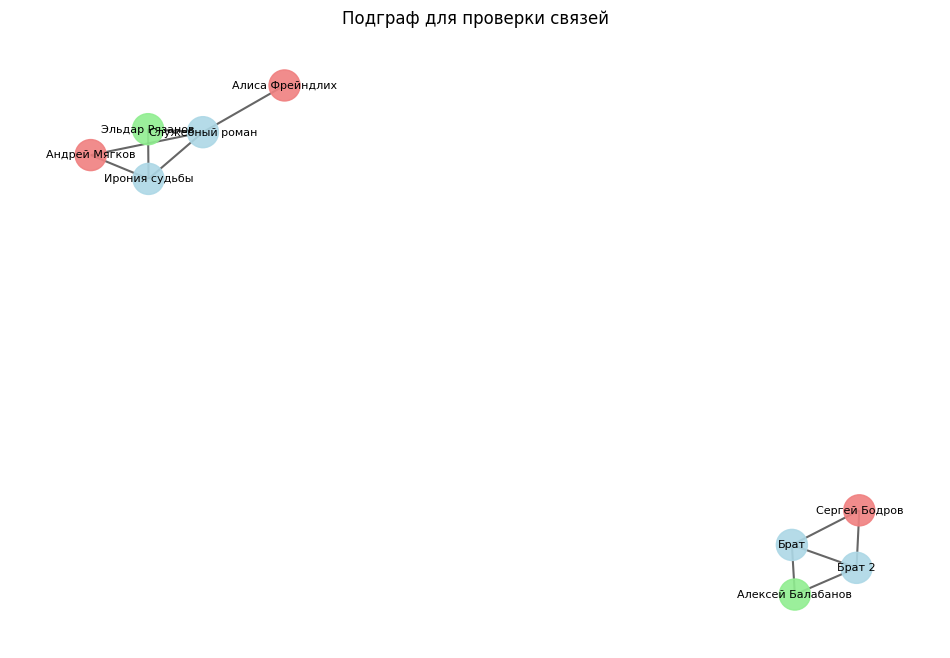

In [28]:
print("СОЗДАНИЕ ПОЛНОГО ГРАФА РОССИЙСКОГО КИНО")

# граф
G_complete = nx.Graph()

# добавляем все фильмы с атрибутами
for genre, film_list in russian_movies_expanded.items():
    for film_info in film_list:
        film_title = film_info['title']
        G_complete.add_node(film_title,
                          genre=genre,
                          year=film_info['year'],
                          rating=film_info['rating'],
                          node_type='film')

# добавляем всех актеров
for actor in actors_films_expanded.keys():
    G_complete.add_node(actor, node_type='actor')

# добавляем всех режиссеров
for director in directors_films_expanded.keys():
    G_complete.add_node(director, node_type='director')

print(f"Добавлено узлов: {G_complete.number_of_nodes()}")
print(f"  - Фильмы: {len([n for n in G_complete.nodes() if G_complete.nodes[n].get('node_type') == 'film'])}")
print(f"  - Актеры: {len([n for n in G_complete.nodes() if G_complete.nodes[n].get('node_type') == 'actor'])}")
print(f"  - Режиссеры: {len([n for n in G_complete.nodes() if G_complete.nodes[n].get('node_type') == 'director'])}")

# добавление связей актер-фильм
actor_connections = 0
for actor, films in actors_films_expanded.items():
    for film in films:
        if film in G_complete.nodes() and actor in G_complete.nodes():
            G_complete.add_edge(actor, film, weight=2.0, relation='acted_in')
            actor_connections += 1

print(f"Добавлено связей актер-фильм: {actor_connections}")

# добавление связей режиссер-фильм
director_connections = 0
for director, films in directors_films_expanded.items():
    for film in films:
        if film in G_complete.nodes() and director in G_complete.nodes():
            G_complete.add_edge(director, film, weight=3.0, relation='directed')
            director_connections += 1

print(f"Добавлено связей режиссер-фильм: {director_connections}")

# добавление связей фильм-фильм (один режиссер)
film_film_connections = 0
for director in directors_films_expanded.keys():
    director_films = [film for film in directors_films_expanded[director] if film in G_complete.nodes()]
    for i, film1 in enumerate(director_films):
        for film2 in director_films[i+1:]:
            if not G_complete.has_edge(film1, film2):
                G_complete.add_edge(film1, film2, weight=1.5, relation='same_director')
                film_film_connections += 1

print(f"Добавлено связей фильм-фильм: {film_film_connections} (один режиссер)")

# добавление связей фильм-фильм (один актер)
for actor in actors_films_expanded.keys():
    actor_films = [film for film in actors_films_expanded[actor] if film in G_complete.nodes()]
    for i, film1 in enumerate(actor_films):
        for film2 in actor_films[i+1:]:
            if not G_complete.has_edge(film1, film2):
                G_complete.add_edge(film1, film2, weight=1.2, relation='same_actor')

print(f"Всего связей в графе: {G_complete.number_of_edges()} (один актер)")

# проверяем целостность графа
print(" ПРОВЕРКА ЦЕЛОСТНОСТИ ГРАФА:")
print(f"Всего узлов: {G_complete.number_of_nodes()}")
print(f"Всего связей: {G_complete.number_of_edges()}")

# несколько ключевых узлов
test_nodes = ['Ирония судьбы', 'Леонид Гайдай', 'Юрий Никулин', 'Брат']
for node in test_nodes:
    if node in G_complete.nodes():
        neighbors = list(G_complete.neighbors(node))
        print(f"  {node}: {len(neighbors)} соседей")
    else:
        print(f"  {node}: ОТСУТСТВУЕТ В ГРАФЕ")

# подграф для проверки
plt.figure(figsize=(12, 8))
subgraph_nodes = []
for film in ['Ирония судьбы', 'Служебный роман', 'Брат', 'Брат 2']:
    if film in G_complete.nodes():
        subgraph_nodes.append(film)
        # добавляем соседей этих фильмов
        neighbors = list(G_complete.neighbors(film))
        subgraph_nodes.extend(neighbors[:3])  # берем первых 3 соседей

subgraph = G_complete.subgraph(subgraph_nodes)
pos = nx.spring_layout(subgraph, seed=42)

# цвета для разных типов узлов
color_map = []
for node in subgraph.nodes():
    node_type = G_complete.nodes[node].get('node_type', 'film')
    if node_type == 'film':
        color_map.append('lightblue')
    elif node_type == 'actor':
        color_map.append('lightcoral')
    else:
        color_map.append('lightgreen')

nx.draw_networkx_nodes(subgraph, pos, node_color=color_map, node_size=500, alpha=0.9)
nx.draw_networkx_edges(subgraph, pos, alpha=0.6, width=1.5)
nx.draw_networkx_labels(subgraph, pos, font_size=8)

plt.title('Подграф для проверки связей')
plt.axis('off')
plt.show()

## Разные типы графов

Различие основных типов графов:

1. Однородный (гомогенный) граф  
   – Все вершины и все рёбра одного «типа», связи основаны на сходстве  
   – Пример: социальная сеть, где все узлы — пользователи, все рёбра — дружба.

2. Гетерогенный граф  
   – Вершины и/или рёбра разных типов, связи между любыми типами  
   – Пример: граф знаний, где вершины бывают «человек», «организация», «событие», а рёбра — «работает в», «участвует в» и т. д.

3. Двудольный (бипартитный) граф  
   – Множество вершин разбито на две доли U и V, рёбра проходят только между U и V, связи только между разными типами    
   – Пример: граф «пользователь–товар» в рекомендательных системах.

4. Взвешенный граф  
   – Каждому ребру присвоен вес wᵢⱼ (стоимость, расстояние, вероятность).  
   – Пример: дорожная сеть с длинами дорог или транспортными расходами.

ТИПЫ ГРАФОВ В РЕКОМЕНДАТЕЛЬНЫХ СИСТЕМАХ
1. ОДНОРОДНЫЙ ГРАФ - только фильмы
   Узлов: 7, Связей: 6
   Пример связей: 'Ирония судьбы'-'Служебный роман' (фильмы Рязанова)

2. ДВУДОЛЬНЫЙ ГРАФ - фильмы и актеры
   Узлов: 8, Связей: 6
   Пример связей: Бриллиантовая рука - Юрий Никулин

3. ГЕТЕРОГЕННЫЙ ГРАФ - фильмы, актеры, режиссеры
   Узлов: 9, Связей: 8
   Пример связей: Ирония судьбы ↔ Андрей Мягков ↔ Эльдар Рязанов

4. ВЗВЕШЕННЫЙ ГРАФ - связи имеют разную силу
   Узлов: 5, Связей: 5
   Пример весов: Брат ↔ Брат 2 (вес 5.0) - сиквел
 ВИЗУАЛИЗАЦИЯ ТИПОВ ГРАФОВ


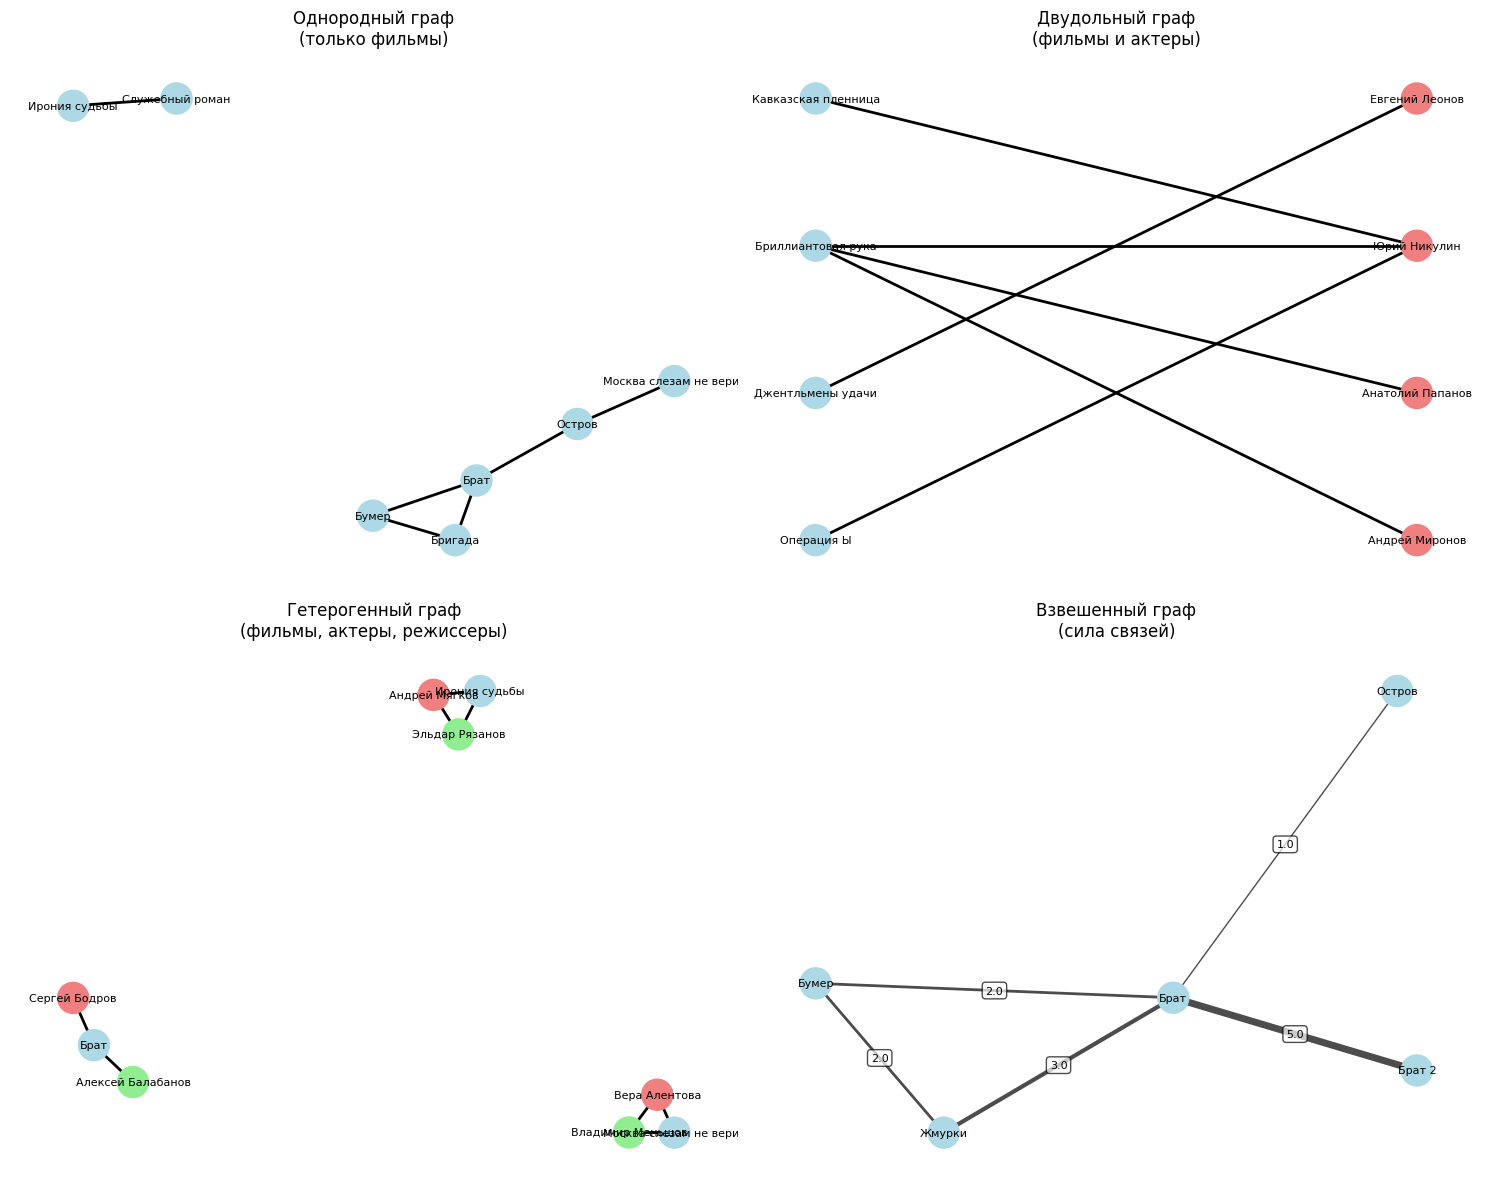

СРАВНИТЕЛЬНАЯ ТАБЛИЦА ТИПОВ ГРАФОВ
ТИП ГРАФА                 УЗЛОВ    СВЯЗЕЙ   ПРИМЕР ИСПОЛЬЗОВАНИЯ                    
--------------------------------------------------------------------------------
Однородный                7        6        Рекомендации по сходству фильмов        
Двудольный                8        6        Фильмы через общих актеров              
Гетерогенный              9        8        Комплексные рекомендации                
Взвешенный                5        5        Учет силы отношений                     


In [29]:
print("ТИПЫ ГРАФОВ В РЕКОМЕНДАТЕЛЬНЫХ СИСТЕМАХ")

print("1. ОДНОРОДНЫЙ ГРАФ - только фильмы")
G_homogeneous = nx.Graph()

#  фильмы из разных жанров для демонстрации
films_homo = [
    'Брат', 'Бригада', 'Бумер',           # криминал/боевик
    'Ирония судьбы', 'Служебный роман',   # комедии
    'Москва слезам не верит', 'Остров'    # драмы
]

for film in films_homo:
    # жанр фильма
    genre = next((g for g, films in russian_movies_expanded.items()
                 if film in [f['title'] for f in films]), 'неизвестно')
    G_homogeneous.add_node(film, genre=genre)

# связи основаны на жанровом сходстве и тематике
connections_homo = [
    # криминальные фильмы
    ('Брат', 'Бригада'), ('Брат', 'Бумер'), ('Бригада', 'Бумер'),
    # комедии Рязанова
    ('Ирония судьбы', 'Служебный роман'),
    # драмы
    ('Москва слезам не верит', 'Остров'),
    # связи между разными жанрами с меньшим весом
    ('Брат', 'Остров')
]
G_homogeneous.add_edges_from(connections_homo)

print(f"   Узлов: {G_homogeneous.number_of_nodes()}, Связей: {G_homogeneous.number_of_edges()}")
print("   Пример связей: 'Ирония судьбы'-'Служебный роман' (фильмы Рязанова)")
print()


print("2. ДВУДОЛЬНЫЙ ГРАФ - фильмы и актеры")
G_bipartite = nx.Graph()
#  фильмы
films_bipartite = ['Бриллиантовая рука', 'Операция Ы', 'Кавказская пленница', 'Джентльмены удачи']
for film in films_bipartite:
    G_bipartite.add_node(film, type='film')

# актеры
actors_bipartite = ['Юрий Никулин', 'Андрей Миронов', 'Анатолий Папанов', 'Евгений Леонов']
for actor in actors_bipartite:
    G_bipartite.add_node(actor, type='actor')

# связи фильм-актер (только между разными типами)
connections_bipartite = [
    ('Бриллиантовая рука', 'Юрий Никулин'),
    ('Бриллиантовая рука', 'Андрей Миронов'),
    ('Бриллиантовая рука', 'Анатолий Папанов'),
    ('Операция Ы', 'Юрий Никулин'),
    ('Кавказская пленница', 'Юрий Никулин'),
    ('Джентльмены удачи', 'Евгений Леонов')
]

G_bipartite.add_edges_from(connections_bipartite)

print(f"   Узлов: {G_bipartite.number_of_nodes()}, Связей: {G_bipartite.number_of_edges()}")
print("   Пример связей: Бриллиантовая рука - Юрий Никулин")


print("3. ГЕТЕРОГЕННЫЙ ГРАФ - фильмы, актеры, режиссеры")
G_heterogeneous = nx.Graph()

# фильмы
films_hetero = ['Ирония судьбы', 'Москва слезам не верит', 'Брат']
for film in films_hetero:
    G_heterogeneous.add_node(film, type='film')

# актеры
actors_hetero = ['Андрей Мягков', 'Вера Алентова', 'Сергей Бодров']
for actor in actors_hetero:
    G_heterogeneous.add_node(actor, type='actor')

# режиссеры
directors_hetero = ['Эльдар Рязанов', 'Владимир Меньшов', 'Алексей Балабанов']
for director in directors_hetero:
    G_heterogeneous.add_node(director, type='director')

# разнотипные связи
connections_hetero = [
    # фильм-актер
    ('Ирония судьбы', 'Андрей Мягков'),
    ('Москва слезам не верит', 'Вера Алентова'),
    ('Брат', 'Сергей Бодров'),
    # фильм-режиссер
    ('Ирония судьбы', 'Эльдар Рязанов'),
    ('Москва слезам не верит', 'Владимир Меньшов'),
    ('Брат', 'Алексей Балабанов'),
    # актер-режиссер
    ('Андрей Мягков', 'Эльдар Рязанов'),
    ('Вера Алентова', 'Владимир Меньшов')
]

G_heterogeneous.add_edges_from(connections_hetero)
print(f"   Узлов: {G_heterogeneous.number_of_nodes()}, Связей: {G_heterogeneous.number_of_edges()}")
print("   Пример связей: Ирония судьбы ↔ Андрей Мягков ↔ Эльдар Рязанов")
print()

print("4. ВЗВЕШЕННЫЙ ГРАФ - связи имеют разную силу")
G_weighted = nx.Graph()

films_weighted = ['Брат', 'Брат 2', 'Жмурки', 'Бумер', 'Остров']
for film in films_weighted:
    G_weighted.add_node(film)

# cвязи с разными весами
weighted_connections = [
    ('Брат', 'Брат 2', 5.0),      # cиквел - самая сильная связь
    ('Брат', 'Жмурки', 3.0),      # один режиссер
    ('Брат', 'Бумер', 2.0),       # один жанр, эпоха
    ('Брат', 'Остров', 1.0),      # разные жанры, слабая связь
    ('Жмурки', 'Бумер', 2.0),     # одна эпоха, криминальная тема
]

for film1, film2, weight in weighted_connections:
    G_weighted.add_edge(film1, film2, weight=weight)

print(f"   Узлов: {G_weighted.number_of_nodes()}, Связей: {G_weighted.number_of_edges()}")
print("   Пример весов: Брат ↔ Брат 2 (вес 5.0) - сиквел")


print(" ВИЗУАЛИЗАЦИЯ ТИПОВ ГРАФОВ")
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# однородный граф
ax1 = axes[0, 0]
pos1 = nx.spring_layout(G_homogeneous, seed=42)
colors1 = ['lightblue' for _ in G_homogeneous.nodes()]
nx.draw_networkx_nodes(G_homogeneous, pos1, node_color=colors1, ax=ax1, node_size=500)
nx.draw_networkx_edges(G_homogeneous, pos1, ax=ax1, width=2)
nx.draw_networkx_labels(G_homogeneous, pos1, ax=ax1, font_size=8)
ax1.set_title('Однородный граф\n(только фильмы)', fontsize=12)
ax1.axis('off')

# двудольный граф
ax2 = axes[0, 1]
pos2 = nx.bipartite_layout(G_bipartite, [n for n in G_bipartite.nodes()
                                       if G_bipartite.nodes[n]['type'] == 'film'])
colors2 = ['lightblue' if G_bipartite.nodes[n]['type'] == 'film'
          else 'lightcoral' for n in G_bipartite.nodes()]
nx.draw_networkx_nodes(G_bipartite, pos2, node_color=colors2, ax=ax2, node_size=500)
nx.draw_networkx_edges(G_bipartite, pos2, ax=ax2, width=2)
nx.draw_networkx_labels(G_bipartite, pos2, ax=ax2, font_size=8)
ax2.set_title('Двудольный граф\n(фильмы и актеры)', fontsize=12)
ax2.axis('off')

# гетерогенный граф
ax3 = axes[1, 0]
pos3 = nx.spring_layout(G_heterogeneous, seed=42)
colors3 = []
for n in G_heterogeneous.nodes():
    if G_heterogeneous.nodes[n]['type'] == 'film':
        colors3.append('lightblue')
    elif G_heterogeneous.nodes[n]['type'] == 'actor':
        colors3.append('lightcoral')
    else:
        colors3.append('lightgreen')
nx.draw_networkx_nodes(G_heterogeneous, pos3, node_color=colors3, ax=ax3, node_size=500)
nx.draw_networkx_edges(G_heterogeneous, pos3, ax=ax3, width=2)
nx.draw_networkx_labels(G_heterogeneous, pos3, ax=ax3, font_size=8)
ax3.set_title('Гетерогенный граф\n(фильмы, актеры, режиссеры)', fontsize=12)
ax3.axis('off')

# взвешенный граф
ax4 = axes[1, 1]
pos4 = nx.spring_layout(G_weighted, seed=42)
colors4 = ['lightblue' for _ in G_weighted.nodes()]
edges = G_weighted.edges()
weights = [G_weighted[u][v]['weight'] for u, v in edges]
nx.draw_networkx_nodes(G_weighted, pos4, node_color=colors4, ax=ax4, node_size=500)
nx.draw_networkx_edges(G_weighted, pos4, ax=ax4, width=weights, alpha=0.7)
nx.draw_networkx_labels(G_weighted, pos4, ax=ax4, font_size=8)

# подписи весов
for (u, v), weight in zip(edges, weights):
    x = (pos4[u][0] + pos4[v][0]) / 2
    y = (pos4[u][1] + pos4[v][1]) / 2
    ax4.text(x, y, f'{weight}', fontsize=8, ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

ax4.set_title('Взвешенный граф\n(сила связей)', fontsize=12)
ax4.axis('off')

plt.tight_layout()
plt.show()

print("СРАВНИТЕЛЬНАЯ ТАБЛИЦА ТИПОВ ГРАФОВ")
print(f"{'ТИП ГРАФА':<25} {'УЗЛОВ':<8} {'СВЯЗЕЙ':<8} {'ПРИМЕР ИСПОЛЬЗОВАНИЯ':<40}")
print("-" * 80)
print(f"{'Однородный':<25} {G_homogeneous.number_of_nodes():<8} {G_homogeneous.number_of_edges():<8} {'Рекомендации по сходству фильмов':<40}")
print(f"{'Двудольный':<25} {G_bipartite.number_of_nodes():<8} {G_bipartite.number_of_edges():<8} {'Фильмы через общих актеров':<40}")
print(f"{'Гетерогенный':<25} {G_heterogeneous.number_of_nodes():<8} {G_heterogeneous.number_of_edges():<8} {'Комплексные рекомендации':<40}")
print(f"{'Взвешенный':<25} {G_weighted.number_of_nodes():<8} {G_weighted.number_of_edges():<8} {'Учет силы отношений':<40}")



ПРЕИМУЩЕСТВА КАЖДОГО ТИПА ГРАФА

• ОДНОРОДНЫЙ: Простота, быстрые вычисления, легко интерпретировать

• ДВУДОЛЬНЫЙ: Естественное моделирование отношений (фильм-актер)

• ГЕТЕРОГЕННЫЙ: Богатые данные, комплексные рекомендации

• ВЗВЕШЕННЫЙ: Учет силы связей, приоритизация рекомендаций

---

### 1.2 Матрица смежности

$A[i,j] = \begin{cases} 1 & \text{если } (v_i, v_j) \in E \\ 0 & \text{иначе} \end{cases}$

• Взвешенные графы  
  – Вместо ${0,1}$ в ячейках хранят веса ребёр $wᵢⱼ$ (и 0, если ребра нет)  

• Ориентированные vs неориентированные  
  – Для неориентированного A симметрична ($A[i,j]=A[j,i]$)  
  – Для ориентированного симметрия необязательна  

• Связь со степенями вершин  
  – Неориентированный: $deg(i)=∑ⱼA[i,j]$  
  – Ориентированный: $outdeg(i)=∑ⱼA[i,j]$, $indeg(i)=∑ⱼA[j,i]$  


##  Компоненты связности и пути

**Компонента связности** — это максимальное подмножество вершин $C \subseteq V$, такое что для любых двух вершин $u,v \in C$ существует путь из $u$ в $v$.

**Длина пути** между вершинами $v$ и $u$ определяется как минимальное количество ребер, которые нужно пройти, чтобы попасть из $v$ в $u$.


## Метрики анализа графов

### Степень вершины (Degree)

$$\text{deg}(v) = \sum_{u \in V} A[v,u]$$

• $V$  – множество всех вершин графа.  
• $v, u$  – произвольные вершины из V.  
• $A[v,u]$  – элемент матрицы смежности:  
  • в неориентированном невзвешенном графе $A[v,u]=1$, если есть ребро между v и u, иначе 0;  
  • в ориентированном графе $A[v,u]=1$, если есть ребро v→u, иначе 0;  
  • в взвешенном графе $A[v,u]=w_{vu}$ (вес ребра) или 0, если ребра нет.  
• $∑₍u ∈ V₎ A[v,u]$  – сумма по всем вершинам u, даёт общее число (или суммарный вес) рёбер, инцидентных v.  
• $deg(v)$  – выходящая степень в ориентированном графе (или просто степень в неориентированном).


### Центральность по посредничеству (Betweenness Centrality)

$$C_B(v) = \sum_{s \neq v \neq t} \frac{\sigma_{st}(v)}{\sigma_{st}}$$

где  
• $s, t$  – две разные вершины, отличные от v (источник и приёмник).  
• $σₛₜ $ – общее число всех кратчайших путей от s до t.  
• $σₛₜ(v)$  – число тех кратчайших путей от s до t, которые проходят через v.  
• $σₛₜ(v)/σₛₜ$  показывает долю путей через v для конкретной пары (s,t).  
• Суммирование по всем упорядоченным парам $(s,t)$, где $s≠v$ и $t≠v$, даёт меру «насколько часто» v оказывается «посредником» в кратчайших путях.

### Центральность по близости (Closeness Centrality)


$$C_C(v) = \frac{n-1}{\sum_{u \neq v} d(v,u)}$$


где

• $n$  – общее число вершин в графе (|V|).  
• $u$  – любая вершина, отличная от v.  
• $d(v,u)$  – длина кратчайшего пути (в сумме весов или числа рёбер) от v до u.  
• $∑_{u ≠ v} d(v,u)$  – суммарное расстояние от v до всех остальных вершин.  
• $(n − 1)$  – нормирующий множитель, равный числу «других» вершин.  
• В результате чем меньше суммарная сумма расстояний, тем выше C_C(v), то есть тем «ближе» v ко всем остальным.



### Дополнительные концепции графов для РС

 ВАЖНЫЕ МЕТРИКИ ГРАФОВ
----------------------------------------
а) СТЕПЕНЬ УЗЛА (Degree): количество связей узла
   Служебный роман: 3 связей
   Ирония судьбы: 2 связей
   Обыкновенное чудо: 2 связей
б) ЦЕНТРАЛЬНОСТЬ ПО ПОСРЕДНИЧЕСТВУ (Betweenness Centrality)
   Служебный роман: 0.015 - ключевой соединительный узел
   Обыкновенное чудо: 0.007 - ключевой соединительный узел
в) ЦЕНТРАЛЬНОСТЬ ПО БЛИЗОСТИ (Closeness Centrality)
   Служебный роман: 0.176 - близок ко всем другим узлам
   Ирония судьбы: 0.132 - близок ко всем другим узлам
2. КОМПОНЕНТЫ СВЯЗНОСТИ
----------------------------------------
Граф содержит 7 компонент связности:
   Компонента 1: Летят журавли, Москва слезам не верит
   Компонента 2: Ирония судьбы, Служебный роман, Гараж, Сталкер
   Компонента 3: Бриллиантовая рука, Обыкновенное чудо, Тот самый Мюнхгаузен
   Компонента 4: Остров, Левиафан
   Компонента 5: Дурак, Аритмия
   Компонента 6: Андрей Рублев, Война и мир
   Компонента 7: Утомленные солнцем, Сибирский цирюльн

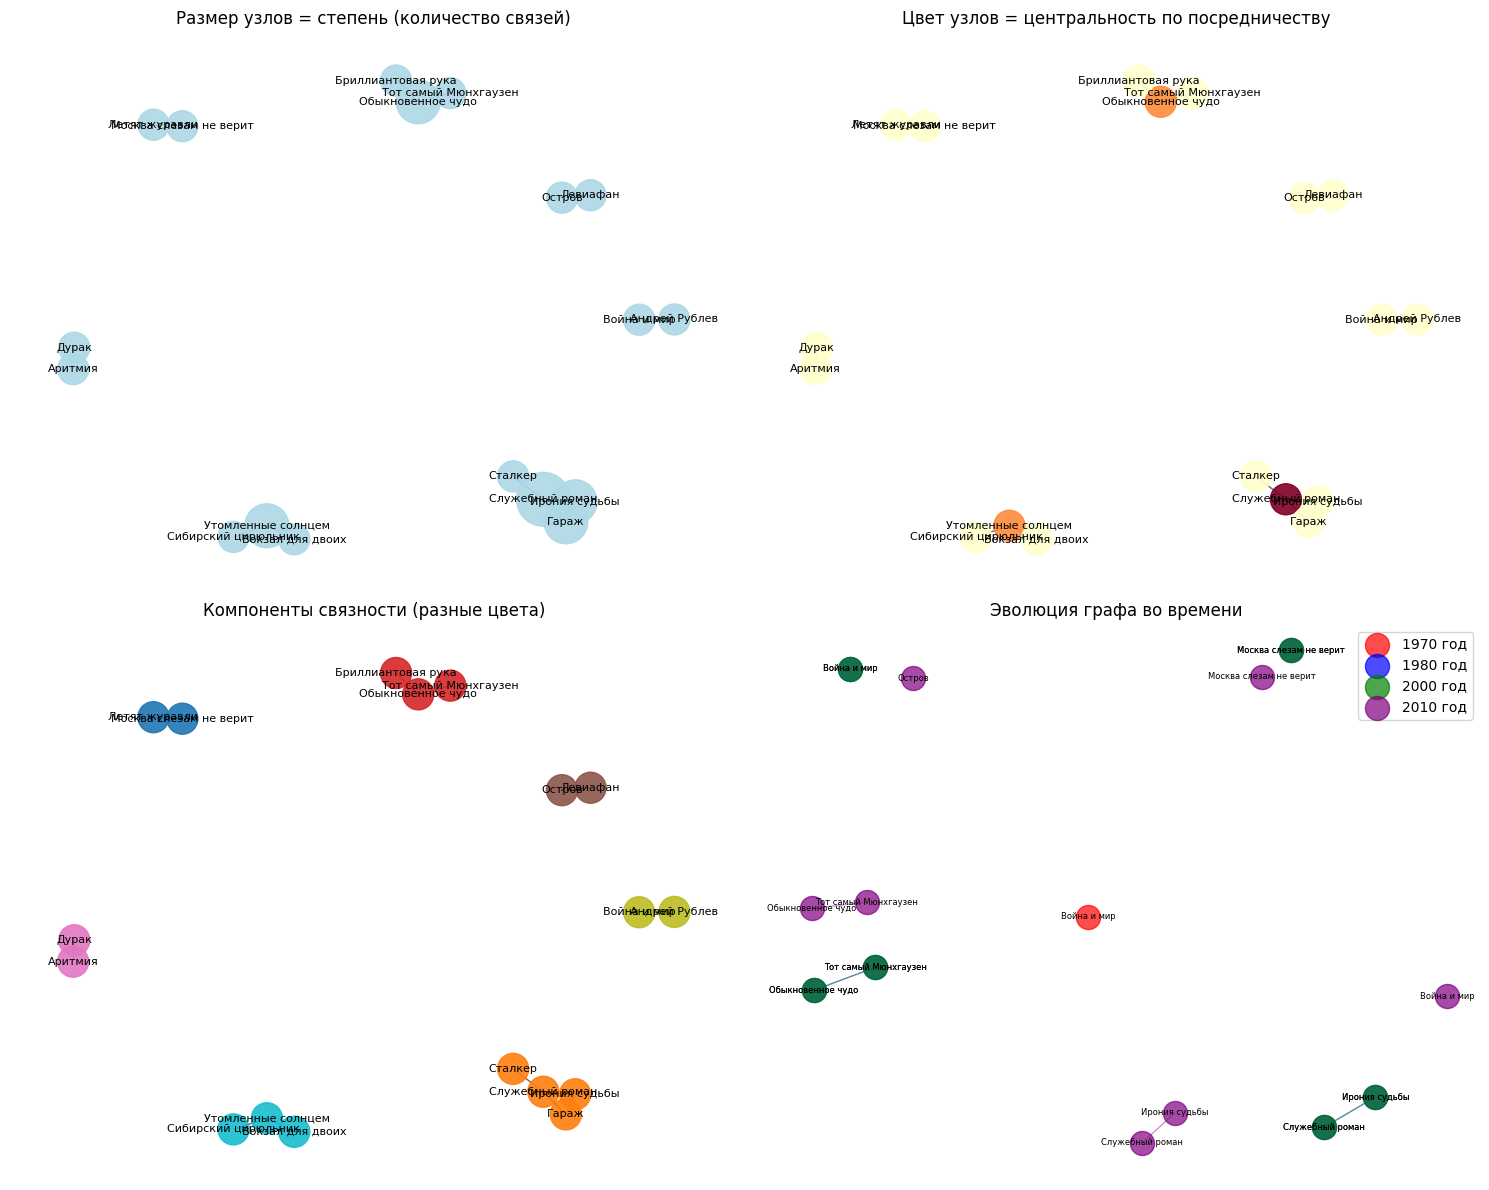

 МАТРИЧНЫЕ ПРЕДСТАВЛЕНИЯ ГРАФА
----------------------------------------
Матрица смежности для выбранных фильмов:
Фильмы: ['Ирония судьбы', 'Служебный роман', 'Обыкновенное чудо', 'Остров', 'Левиафан']
Матрица:
[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]
 ТЕОРИЯ ШЕСТИ РУКОПОЖАТИЙ В КИНО
----------------------------------------
ПРИМЕРЫ ТЕОРИИ 6 РУКОПОЖАТИЙ:
   'Москва слезам не верит' → 'Остров': 1 шагов
   Путь: Москва слезам не верит → Остров
   Связь между 'Ирония судьбы' и 'Остров' не найдена в пределах 3 шагов
   Связь между 'Операция Ы' и 'Аритмия' не найдена в пределах 3 шагов
ПРИМЕР РЕКОМЕНДАЦИЙ НА ОСНОВЕ МЕТРИК:
   Фильмы с наибольшим влиянием: Ирония судьбы, Служебный роман, Обыкновенное чудо, Гараж, Утомленные солнцем
   Ключевые соединительные фильмы: Служебный роман, Обыкновенное чудо
РЕКОМЕНДАЦИИ НА ОСНОВЕ СТРУКТУРЫ ГРАФА
----------------------------------------
   Если вам нравится 'Ирония судьбы', возможно вам понравятся:
   

In [41]:
print(" ВАЖНЫЕ МЕТРИКИ ГРАФОВ")
print("-" * 40)

# демонстрационный граф с фильмами из датасета
G_metrics = nx.Graph()
films_metrics = ['Москва слезам не верит', 'Ирония судьбы', 'Служебный роман',
                'Обыкновенное чудо', 'Тот самый Мюнхгаузен', 'Остров', 'Левиафан',
                'Аритмия', 'Дурак', 'Война и мир']
G_metrics.add_nodes_from(films_metrics)

# создаем связи на основе общих актеров и режиссеров
connections_metrics = [
    # связи через Эльдара Рязанова
    ('Ирония судьбы', 'Служебный роман'), ('Ирония судьбы', 'Гараж'),
    ('Служебный роман', 'Гараж'),

    # связи через Андрея Мягкова
    ('Ирония судьбы', 'Служебный роман'), ('Ирония судьбы', 'Гараж'),

    # связи через Алису Фрейндлих
    ('Служебный роман', 'Сталкер'),

    # связи через Андрея Миронова
    ('Обыкновенное чудо', 'Тот самый Мюнхгаузен'), ('Бриллиантовая рука', 'Обыкновенное чудо'),

    # связи через Никиту Михалкова
    ('Утомленные солнцем', 'Сибирский цирюльник'), ('Утомленные солнцем', 'Вокзал для двоих'),

    # связи драматических фильмов
    ('Москва слезам не верит', 'Летят журавли'), ('Остров', 'Левиафан'),
    ('Аритмия', 'Дурак'), ('Война и мир', 'Андрей Рублев')
]
G_metrics.add_edges_from(connections_metrics)

print("а) СТЕПЕНЬ УЗЛА (Degree): количество связей узла")
degrees = dict(G_metrics.degree())
for film, degree in sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:3]:
    print(f"   {film}: {degree} связей")

print("б) ЦЕНТРАЛЬНОСТЬ ПО ПОСРЕДНИЧЕСТВУ (Betweenness Centrality)")
betweenness = nx.betweenness_centrality(G_metrics)
for film, centrality in sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:2]:
    print(f"   {film}: {centrality:.3f} - ключевой соединительный узел")

print("в) ЦЕНТРАЛЬНОСТЬ ПО БЛИЗОСТИ (Closeness Centrality)")
closeness = nx.closeness_centrality(G_metrics)
for film, centrality in sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:2]:
    print(f"   {film}: {centrality:.3f} - близок ко всем другим узлам")

print("2. КОМПОНЕНТЫ СВЯЗНОСТИ")
print("-" * 40)

components = list(nx.connected_components(G_metrics))
print(f"Граф содержит {len(components)} компонент связности:")
for i, component in enumerate(components, 1):
    print(f"   Компонента {i}: {', '.join(component)}")

print(" ПУТИ И РАССТОЯНИЯ МЕЖДУ ФИЛЬМАМИ")
print("-" * 40)

film_pairs = [('Москва слезам не верит', 'Остров'), ('Ирония судьбы', 'Левиафан'), ('Обыкновенное чудо', 'Война и мир')]
for film1, film2 in film_pairs:
    try:
        path = nx.shortest_path(G_metrics, film1, film2)
        distance = nx.shortest_path_length(G_metrics, film1, film2)
        print(f"   {film1} → {film2}: расстояние {distance}, путь: {' → '.join(path)}")
    except:
        print(f"   {film1} и {film2} не связаны")

print(" ВЫЯВЛЕНИЕ СООБЩЕСТВ В ГРАФЕ")
print("-" * 40)

def detect_communities_simple(graph):
    communities = []
    visited = set()

    for node in graph.nodes():
        if node not in visited:
            # BFS для нахождения связной компоненты
            community = set()
            queue = [node]
            while queue:
                current = queue.pop(0)
                if current not in visited:
                    visited.add(current)
                    community.add(current)
                    queue.extend([n for n in graph.neighbors(current) if n not in visited])
            communities.append(community)

    return communities

communities = detect_communities_simple(G_metrics)
print(f"Найдено {len(communities)} сообществ:")
for i, community in enumerate(communities, 1):
    films = list(community)
    if films:
        #  жанр сообщества
        if any(f in ['Ирония судьбы', 'Служебный роман', 'Гараж'] for f in films):
            genre = "комедии/мелодрамы"
        elif any(f in ['Остров', 'Левиафан', 'Аритмия'] for f in films):
            genre = "современная драма"
        elif any(f in ['Война и мир', 'Андрей Рублев'] for f in films):
            genre = "историческое кино"
        else:
            genre = "классика"
        print(f"   Сообщество {i} ({genre}): {', '.join(films)}")

print(" ДИНАМИЧЕСКИЕ ГРАФЫ - ЭВОЛЮЦИЯ ВО ВРЕМЕНИ")
print("-" * 40)

# временные срезы графа
years = [1970, 1980, 2000, 2010]
graphs_by_year = {}

for year in years:
    G_year = nx.Graph()
    # фильмы до указанного года из нашего датасета
    films_year = []
    for film in films_metrics:
        film_year = None
        for genre, film_list in russian_movies_expanded.items():
            for movie in film_list:
                if movie['title'] == film:
                    film_year = movie['year']
                    break
            if film_year:
                break
        if film_year and film_year <= year:
            films_year.append(film)

    G_year.add_nodes_from(films_year)
    #  связи между существующими фильмами
    for film1 in films_year:
        for film2 in films_year:
            if film1 != film2 and G_metrics.has_edge(film1, film2):
                G_year.add_edge(film1, film2)

    graphs_by_year[year] = G_year
    print(f"   {year} год: {G_year.number_of_nodes()} фильмов, {G_year.number_of_edges()} связей")

print("ВИЗУАЛИЗАЦИЯ МЕТРИК ГРАФА")
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# граф с размерами узлов по степени
ax1 = axes[0, 0]
pos = nx.spring_layout(G_metrics, seed=42)
node_sizes = [degrees[node] * 500 for node in G_metrics.nodes()]
nx.draw_networkx_nodes(G_metrics, pos, node_size=node_sizes,
                      node_color='lightblue', alpha=0.9, ax=ax1)
nx.draw_networkx_edges(G_metrics, pos, alpha=0.6, ax=ax1)
nx.draw_networkx_labels(G_metrics, pos, ax=ax1, font_size=8)
ax1.set_title('Размер узлов = степень (количество связей)', fontsize=12)
ax1.axis('off')

# граф с цветами по betweenness centrality
ax2 = axes[0, 1]
node_colors = [betweenness[node] * 1000 for node in G_metrics.nodes()]
nx.draw_networkx_nodes(G_metrics, pos, node_size=500,
                      node_color=node_colors, cmap='YlOrRd', alpha=0.9, ax=ax2)
nx.draw_networkx_edges(G_metrics, pos, alpha=0.6, ax=ax2)
nx.draw_networkx_labels(G_metrics, pos, ax=ax2, font_size=8)
ax2.set_title('Цвет узлов = центральность по посредничеству', fontsize=12)
ax2.axis('off')

# компоненты связности
ax3 = axes[1, 0]
colors_components = []
for node in G_metrics.nodes():
    for i, component in enumerate(components):
        if node in component:
            colors_components.append(i)
            break

nx.draw_networkx_nodes(G_metrics, pos, node_size=500,
                      node_color=colors_components, cmap='tab10', alpha=0.9, ax=ax3)
nx.draw_networkx_edges(G_metrics, pos, alpha=0.6, ax=ax3)
nx.draw_networkx_labels(G_metrics, pos, ax=ax3, font_size=8)
ax3.set_title('Компоненты связности (разные цвета)', fontsize=12)
ax3.axis('off')

# динамика графа
ax4 = axes[1, 1]
years_to_plot = [1970, 1980, 2000, 2010]
colors_year = ['red', 'blue', 'green', 'purple']
for i, year in enumerate(years_to_plot):
    G_year = graphs_by_year[year]
    if G_year.number_of_nodes() > 0:
        pos_year = nx.spring_layout(G_year, seed=42)
        y_offset = i * 2  # смещение для разных лет


        nx.draw_networkx_nodes(G_year, pos_year, node_size=300,
                              node_color=colors_year[i], alpha=0.7,
                              label=f'{year} год', ax=ax4)

        nx.draw_networkx_edges(G_year, pos_year, alpha=0.4,
                              edge_color=colors_year[i], ax=ax4)

        nx.draw_networkx_labels(G_year, pos_year, font_size=6, ax=ax4)

ax4.set_title('Эволюция графа во времени', fontsize=12)
ax4.legend()
ax4.axis('off')

plt.tight_layout()
plt.show()

print(" МАТРИЧНЫЕ ПРЕДСТАВЛЕНИЯ ГРАФА")
print("-" * 40)

# матрица смежности для выбранных фильмов
selected_films = ['Ирония судьбы', 'Служебный роман', 'Обыкновенное чудо', 'Остров', 'Левиафан']
matrix = np.zeros((5, 5))
for i, n1 in enumerate(selected_films):
    for j, n2 in enumerate(selected_films):
        if G_metrics.has_edge(n1, n2):
            matrix[i, j] = 1

print("Матрица смежности для выбранных фильмов:")
print("Фильмы:", selected_films)
print("Матрица:")
print(matrix)

print(" ТЕОРИЯ ШЕСТИ РУКОПОЖАТИЙ В КИНО")
print("-" * 40)

def find_connection_chain(graph, start, end, max_depth=3):# возьмем 3, так как данных мало
    visited = set()
    queue = [(start, [start])]

    while queue:
        current, path = queue.pop(0)
        if current == end:
            return path

        if len(path) < max_depth:
            for neighbor in graph.neighbors(current):
                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append((neighbor, path + [neighbor]))

    return None

# более связный граф для демонстрации теории 3 рукопожатий
G_connected = nx.Graph()
all_films = []
for genre, film_list in russian_movies_expanded.items():
    for film in film_list:
        all_films.append(film['title'])

# добавляем больше связей через общих актеров и режиссеров
G_connected.add_nodes_from(all_films[:15])  # берем первые 15 фильмов для наглядности

#  плотные связи
additional_connections = []
for i in range(len(all_films[:15])):
    for j in range(i+1, len(all_films[:15])):
        #  связи между фильмами одного режиссера или с общими актерами
        film1, film2 = all_films[i], all_films[j]
        #  фильмы Эльдара Рязанова
        if film1 in ['Ирония судьбы', 'Служебный роман', 'Гараж', 'Вокзал для двоих'] and \
           film2 in ['Ирония судьбы', 'Служебный роман', 'Гараж', 'Вокзал для двоих']:
            additional_connections.append((film1, film2))
        #   фильмы с Андреем Мягковым
        elif film1 in ['Ирония судьбы', 'Служебный роман', 'Гараж'] and \
             film2 in ['Ирония судьбы', 'Служебный роман', 'Гараж']:
            additional_connections.append((film1, film2))
        #  драматические фильмы
        elif film1 in ['Москва слезам не верит', 'Летят журавли', 'Остров'] and \
             film2 in ['Москва слезам не верит', 'Летят журавли', 'Остров']:
            additional_connections.append((film1, film2))

G_connected.add_edges_from(additional_connections)

film_pairs_6handshakes = [
    ('Москва слезам не верит', 'Остров'),
    ('Ирония судьбы', 'Остров'),
    ('Операция Ы', 'Аритмия')
]

print("ПРИМЕРЫ ТЕОРИИ 6 РУКОПОЖАТИЙ:")
for film1, film2 in film_pairs_6handshakes:
    if film1 in G_connected.nodes() and film2 in G_connected.nodes():
        film_chain = find_connection_chain(G_connected, film1, film2)
        if film_chain:
            print(f"   '{film1}' → '{film2}': {len(film_chain)-1} шагов")
            print(f"   Путь: {' → '.join(film_chain)}")
        else:
            print(f"   Связь между '{film1}' и '{film2}' не найдена в пределах 3 шагов")
    else:
        print(f"   Один из фильмов отсутствует в графе")



print("ПРИМЕР РЕКОМЕНДАЦИЙ НА ОСНОВЕ МЕТРИК:")
high_degree_films = [film for film, deg in degrees.items() if deg >= 2]
if high_degree_films:
    print(f"   Фильмы с наибольшим влиянием: {', '.join(high_degree_films)}")

high_betweenness_films = [film for film, bet in betweenness.items() if bet > 0]
if high_betweenness_films:
    print(f"   Ключевые соединительные фильмы: {', '.join(sorted(high_betweenness_films, key=lambda x: betweenness[x], reverse=True)[:2])}")

print("РЕКОМЕНДАЦИИ НА ОСНОВЕ СТРУКТУРЫ ГРАФА")
print("-" * 40)

def recommend_similar_films(graph, target_film, n_recommendations=3):
    """Рекомендует фильмы на основе общих связей"""
    if target_film not in graph:
        return []

    recommendations = {}
    target_neighbors = set(graph.neighbors(target_film))

    for film in graph.nodes():
        if film != target_film and not graph.has_edge(target_film, film):
            film_neighbors = set(graph.neighbors(film))
            common_neighbors = target_neighbors.intersection(film_neighbors)
            if common_neighbors:
                recommendations[film] = len(common_neighbors)

    return sorted(recommendations.items(), key=lambda x: x[1], reverse=True)[:n_recommendations]

# пример
test_films = ['Ирония судьбы', 'Москва слезам не верит']
for film in test_films:
    recs = recommend_similar_films(G_metrics, film)
    if recs:
        print(f"   Если вам нравится '{film}', возможно вам понравятся:")
        for rec_film, score in recs:
            print(f"     • {rec_film} (общих связей: {score})")
    print()

### Практическое применение метрик

 • Степень узла: популярные фильмы для рекомендаций новым пользователям

 • Центральность: фильмы-«мосты» между разными жанрами

 • Центральность по близости: универсальные фильмы для широкой аудитории

 • Сообщества: рекомендации внутри тематических кластеров

 • Пути: нахождение связей между разными фильмами

## ЧАСТЬ 2: ТЕОРИЯ - NODE2VEC

### 2.1 Идея векторных представлений
$f: V \to \mathbb{R}^d$ где $\text{sim}(f(u), f(v)) \approx \text{структурное сходство}(u, v)$

### 2.2 Формула вероятностей перехода
$P(c(i+1) = x \mid c(i) = v, c(i-1) = t) = \begin{cases}
\frac{1}{p} & \text{если } d(t,x) = 0 \\
1 & \text{если } d(t,x) = 1 \\
\frac{1}{q} & \text{если } d(t,x) = 2
\end{cases}$

**Компоненты:**
- $p$ - параметр возврата
- $q$ - параметр исследования  
- $d(t,x)$ - расстояние между вершинами
- $c$  — функция, которая каждому шагу i прогулки ставит в соответствие посещённую вершину c(i).  
- $c(0), c(1), c(2), … $— последовательность вершин, по которым «ходит» алгоритм.  
- В частности $c(i–1)=t$ — предыдущая вершина, $c(i)=v$ — текущая, $c(i+1)=x$ — следующая.  

Таким образом $P(c(i+1)=x | c(i)=v, c(i–1)=t)$ — это вероятность того, что из v мы перейдём в x, имея память о том, что до v мы пришли из t.

In [31]:
print(" ИНТЕРАКТИВНЫЕ СЛУЧАЙНЫЕ БЛУЖДАНИЯ")

def interactive_random_walks(start_movie='Ирония судьбы', num_walks=3, walk_length=6):
    clear_output(wait=True)
    print(f" Случайные блуждания из '{start_movie}':")

    for walk_num in range(num_walks):
        walk = [start_movie]
        current = start_movie
        for step in range(walk_length):
            neighbors = list(G_complete.neighbors(current))
            if neighbors:
                next_node = random.choice(neighbors)
                walk.append(next_node)
                current = next_node
            else: break
        print(f"Блуждание {walk_num+1}: {' → '.join(walk)}")

print(" ИССЛЕДУЙТЕ СЛУЧАЙНЫЕ БЛУЖДАНИЯ:")
interact(interactive_random_walks,
         start_movie=widgets.Dropdown(options=['Ирония судьбы', 'Чародеи', 'Ночной дозор'], value='Ирония судьбы'),
         num_walks=widgets.IntSlider(value=3, min=1, max=5),
         walk_length=widgets.IntSlider(value=6, min=3, max=10))

 ИНТЕРАКТИВНЫЕ СЛУЧАЙНЫЕ БЛУЖДАНИЯ
 ИССЛЕДУЙТЕ СЛУЧАЙНЫЕ БЛУЖДАНИЯ:


interactive(children=(Dropdown(description='start_movie', options=('Ирония судьбы', 'Чародеи', 'Ночной дозор')…

<function __main__.interactive_random_walks(start_movie='Ирония судьбы', num_walks=3, walk_length=6)>

# ПАРАМЕТРЫ P И Q В NODE2VEC. УПРАВЛЯЕМЫЕ БЛУЖДАНИЯ

##  P - Параметр возврата
**Контролирует вероятность вернуться к предыдущей вершине**

- **P > 1** - избегаем возврата (исследование новых вершин)
- **P < 1** - часто возвращаемся (углубление в локальную область)

##  Q - Параметр исследования  
**Контролирует баланс между локальными и дальними переходами**

- **Q > 1** - предпочитаем локальные связи (BFS-стратегия)
- **Q < 1** - предпочитаем дальние переходы (DFS-стратегия)

 1. Обход в ширину (BFS – Breadth-First Search)  
   – Алгоритм, который начинает от заданной стартовой вершины, сначала посещает все её «соседей» (вершины на расстоянии 1), затем всех соседей этих соседей (расстояние 2) и т. д.  
   – Реализуется с помощью очереди.  
   – Применения: поиск кратчайшего пути в невзвешенном графе, проверка связности, построение остовного дерева.

 2. Обход в глубину (DFS – Depth-First Search)  
   – Алгоритм, который идёт «как можно дальше» по одному пути, пока не встретит вершину без непосещённых соседей, затем откатывается назад и продолжает с других соседей.  
   – Реализуется рекурсивно или с помощью стека.  
   – Применения: топологическая сортировка (для DAG), поиск компонент сильной связности, проверка наличия цикла.


## СТРАТЕГИИ:
- **Биограф**: P < 1, Q > 1 (изучает актерские составы)
- **Исследователь**: P > 1, Q < 1 (открывает новые жанры)
- **Сбалансированный**: P = 1, Q = 1

In [32]:
print(" ВИЗУАЛИЗАЦИЯ ВЕРОЯТНОСТЕЙ ПЕРЕХОДА")

def plot_probabilities_interactive(p=1.0, q=1.0):
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(10, 6))

    distances = ['Возврат (d=0)', 'Шаг к соседу (d=1)', 'Уход дальше (d=2)']
    probabilities = [1/p, 1, 1/q]

    bars = ax.bar(distances, probabilities, color=['red', 'blue', 'green'], alpha=0.7)
    ax.set_ylabel('Вероятность перехода')
    ax.set_title(f'Вероятности перехода (p={p}, q={q})')
    ax.grid(True, alpha=0.3)

    for bar, prob in zip(bars, probabilities):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, f'{prob:.2f}', ha='center')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    if p < 1.0 and q > 1.0:
        print(" СТРАТЕГИЯ:  БИОГРАФ - ищет связи через актёров")
    elif p > 1.0 and q < 1.0:
        print(" СТРАТЕГИЯ: ИССЛЕДОВАТЕЛЬ ЖАНРОВ - изучает смежные жанры")
    else:
        print(" СТРАТЕГИЯ:  СБАЛАНСИРОВАННЫЙ")

print(" ИССЛЕДУЙТЕ ПАРАМЕТРЫ P И Q:")
interact(plot_probabilities_interactive,
         p=widgets.FloatSlider(value=1.0, min=0.5, max=2.0, step=0.1),
         q=widgets.FloatSlider(value=1.0, min=0.5, max=2.0, step=0.1))

 ВИЗУАЛИЗАЦИЯ ВЕРОЯТНОСТЕЙ ПЕРЕХОДА
 ИССЛЕДУЙТЕ ПАРАМЕТРЫ P И Q:


interactive(children=(FloatSlider(value=1.0, description='p', max=2.0, min=0.5), FloatSlider(value=1.0, descri…

<function __main__.plot_probabilities_interactive(p=1.0, q=1.0)>

##  ЧАСТЬ 3: ТЕОРИЯ - ОБУЧЕНИЕ ВЕКТОРОВ

А, тогда это совсем другой контекст! В **Node2Vec** эти формулы работают для **узлов графа**, а не для слов.

## 3.1 Skip-gram для графов

**Формула:**
$$\max \sum_{v \in V} \log P(N_S(v) \mid f(v))$$

**Теперь это означает:**
- **$v \in V$** - все узлы графа (люди, товары, страницы)
- **$f(v)$** - векторное представление узла $v$
- **$N_S(v)$** - "соседи" узла $v$, найденные через случайные блуждания

**Суть:** Мы хотим, чтобы векторные представления узлов были такими, чтобы можно было предсказать, какие узлы будут встречаться в одном случайном блуждании.

**Пример:** В социальной сети для пользователя "Алиса" ($v$) мы хотим, чтобы её вектор предсказывал её друзей и друзей друзей ($N_S(v)$), которых мы находим случайными блужданиями по графу.

---

## 3.2 Negative Sampling для графов

**Формула остаётся той же, но смысл меняется:**

### Часть 1: Положительные примеры
$$\log \sigma(f(v) \cdot f(u))$$

- **$f(v) \cdot f(u)$** - скалярное произведение векторов узлов $v$ и $u$, которые встретились в одном случайном блуждании
- Увеличиваем схожесть узлов, которые "близки" в графе

### Часть 2: Отрицательные примеры  
$$\sum_{i=1}^k \mathbb{E}_{n_i \sim P_n} [\log \sigma(-f(v) \cdot f(n_i))]$$

- **$n_i$** - случайные узлы из графа, которые НЕ встречались с $v$ в блужданиях
- Уменьшаем схожесть с случайно выбранными "далёкими" узлами

---


В Node2Vec с Negative Sampling мы используем следующую функцию потерь:

$$
\mathcal{L} = -\left[ \log \sigma(f(v) \cdot f(c)) + \sum_{i=1}^k \mathbb{E}_{n_i \sim P_n} \log \sigma(-f(v) \cdot f(n_i)) \right]
$$

Положительные примеры
$$
\log \sigma(f(v) \cdot f(c))
$$

Что здесь происходит:
- $f(v)$ - вектор целевой вершины (например, "Андрей Мягков")
- $f(c)$ - вектор контекстной вершины (например, "Ирония судьбы")
- $f(v) \cdot f(c)$ - скалярное произведение (мера сходства)
- $\sigma(x) = \frac{1}{1 + e^{-x}}$ - сигмоида, превращает сходство в вероятность
- $\log$ - логарифм вероятности

 Отрицательные примеры
$$
\sum_{i=1}^k \mathbb{E}_{n_i \sim P_n} \log \sigma(-f(v) \cdot f(n_i))
$$

Что здесь происходит:
- $n_i$ - случайные вершины (отрицательные примеры)
- $f(v) \cdot f(n_i)$ - сходство с случайными вершинами
- $\sigma(-f(v) \cdot f(n_i))$ - вероятность того, что они НЕ связаны
- Суммируем по k отрицательным примерам


Проверка и добавление весов ребер...
Проверено 76 ребер
Запуск CompleteNode2Vec на полном графе
Инициализирован CompleteNode2Vec для графа с 71 узлами
Предвычисление вероятностей переходов...
Успешно обработано 50/71 узлов
Начало обучения CompleteNode2Vec...
Генерация тренировочных данных...
Успешно сгенерировано 750/1065 блужданий
Создано 338486 тренировочных пар
Эпоха 1/5, Средний Loss: 0.7235
Эпоха 2/5, Средний Loss: 0.6853
Эпоха 3/5, Средний Loss: 0.6830
Эпоха 4/5, Средний Loss: 0.6792
Эпоха 5/5, Средний Loss: 0.6799


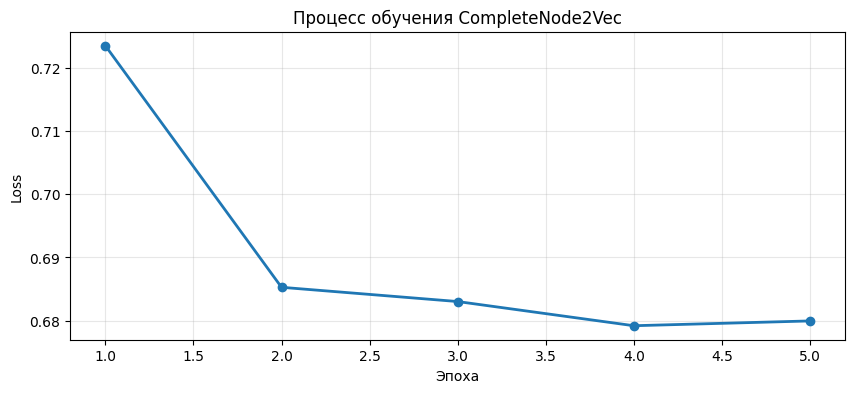

Обучение CompleteNode2Vec завершено!
Размерность эмбеддингов: 71 узлов, 64 признаков
АНАЛИЗ КАЧЕСТВА ЭМБЕДДИНГОВ:
Средняя норма векторов: 2.730 (±1.839)
Проверка ключевых фильмов в эмбеддингах:
• Ирония судьбы: присутствует (норма: 3.333)
• Брат: присутствует (норма: 3.706)
• Ночной дозор: присутствует (норма: 3.673)
• Остров: присутствует (норма: 4.442)
• Джентльмены удачи: присутствует (норма: 4.384)


In [33]:
# импортируем полную версию Node2Vec
from node2vec_complete import CompleteNode2Vec

# убедимся, что все ребра имеют веса
print("Проверка и добавление весов ребер...")
for u, v in G_complete.edges():
    if 'weight' not in G_complete[u][v]:
        # определяем вес на основе типа узлов
        u_type = G_complete.nodes[u].get('node_type', 'film')
        v_type = G_complete.nodes[v].get('node_type', 'film')

        if u_type == 'actor' or v_type == 'actor':
            G_complete[u][v]['weight'] = 2.0
        elif u_type == 'director' or v_type == 'director':
            G_complete[u][v]['weight'] = 3.0
        else:
            G_complete[u][v]['weight'] = 1.0

print(f"Проверено {G_complete.number_of_edges()} ребер")


print("Запуск CompleteNode2Vec на полном графе")
complete_node2vec = CompleteNode2Vec(
    G_complete,
    dimensions=64,    # уменьшим для скорости
    walk_length=30,   # уменьшим для стабильности
    num_walks=15,     # уменьшим для тестирования
    window_size=5,
    num_negatives=3,
    p=1.0,
    q=1.0
)

complete_embeddings = complete_node2vec.train(epochs=5, learning_rate=0.025, batch_size=128, device=device)
global_embeddings = complete_embeddings

if complete_embeddings:
    print(f"Размерность эмбеддингов: {len(complete_embeddings)} узлов, {len(list(complete_embeddings.values())[0])} признаков")

    print("АНАЛИЗ КАЧЕСТВА ЭМБЕДДИНГОВ:")
    norms = [np.linalg.norm(vec) for vec in complete_embeddings.values()]
    print(f"Средняя норма векторов: {np.mean(norms):.3f} (±{np.std(norms):.3f})")

    test_films = ['Ирония судьбы', 'Брат', 'Ночной дозор', 'Остров', 'Джентльмены удачи']
    print("Проверка ключевых фильмов в эмбеддингах:")
    for film in test_films:
        if film in complete_embeddings:
            vec = complete_embeddings[film]
            print(f"• {film}: присутствует (норма: {np.linalg.norm(vec):.3f})")
        else:
            print(f"• {film}: ОТСУТСТВУЕТ")
else:
    print("Не удалось обучить модель")

In [34]:
global_embeddings = None

def interactive_training(dimensions=64, walk_length=20, num_walks=10,
                        window_size=5, num_negatives=3, learning_rate=0.025,
                        epochs=3, p=1.0, q=1.0):

    global global_embeddings
    clear_output(wait=True)

    print("ИНТЕРАКТИВНОЕ ОБУЧЕНИЕ NODE2VEC")
    print("=" * 50)

    model = CompleteNode2Vec(
        G_complete,
        dimensions=dimensions,
        walk_length=walk_length,
        num_walks=num_walks,
        window_size=window_size,
        num_negatives=num_negatives,
        p=p,
        q=q
    )
    embeddings = model.train(learning_rate=learning_rate, epochs=epochs, batch_size=128)
    global_embeddings = embeddings

    if not embeddings:
        print("Не удалось обучить модель. Попробуйте другие параметры.")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # векторы в 2D с использованием PCA
    films_to_visualize = ['Ирония судьбы', 'Служебный роман', 'Брат', 'Брат 2', 'Ночной дозор']
    vectors = []
    labels = []

    for film in films_to_visualize:
        if film in embeddings:
            vectors.append(embeddings[film])
            labels.append(film)

    if vectors:
        vectors = np.array(vectors)
        pca = PCA(n_components=2)
        vectors_2d = pca.fit_transform(vectors)

        colors = ['red', 'blue', 'green', 'purple', 'orange']
        for i, (vec, label) in enumerate(zip(vectors_2d, labels)):
            ax1.scatter(vec[0], vec[1], s=100, color=colors[i], alpha=0.7, label=label)
            ax1.annotate(label, (vec[0], vec[1]), xytext=(5, 5), textcoords='offset points')

        ax1.set_title('Векторные представления фильмов (PCA)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_xlabel('Главная компонента 1')
        ax1.set_ylabel('Главная компонента 2')
    else:
        ax1.text(0.5, 0.5, 'Недостаточно данных\nдля визуализации',
                ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('Векторные представления')

    # матрица сходства
    similarity_matrix = np.zeros((len(films_to_visualize), len(films_to_visualize)))
    available_films = [f for f in films_to_visualize if f in embeddings]

    if len(available_films) > 1:
        for i, f1 in enumerate(available_films):
            for j, f2 in enumerate(available_films):
                vec1 = embeddings[f1]
                vec2 = embeddings[f2]
                sim = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
                similarity_matrix[i, j] = sim

        im = ax2.imshow(similarity_matrix[:len(available_films), :len(available_films)],
                       cmap='RdYlBu', vmin=-1, vmax=1)
        for i in range(len(available_films)):
            for j in range(len(available_films)):
                ax2.text(j, i, f'{similarity_matrix[i, j]:.2f}', ha='center', va='center',
                        fontweight='bold', fontsize=10)

        ax2.set_xticks(range(len(available_films)))
        ax2.set_yticks(range(len(available_films)))
        ax2.set_xticklabels(available_films, rotation=45)
        ax2.set_yticklabels(available_films)
        ax2.set_title('Матрица косинусного сходства')
        plt.colorbar(im, ax=ax2)
    else:
        ax2.text(0.5, 0.5, 'Недостаточно данных\nдля матрицы сходства',
                ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Матрица сходства')

    plt.tight_layout()
    plt.show()


    print("АНАЛИЗ РЕЗУЛЬТАТОВ:")
    print(f"Обучено эмбеддингов: {len(embeddings)}")

    # проверяем качество на тестовых парах
    test_pairs = [
        ('Ирония судьбы', 'Служебный роман'),  # должны быть похожи
        ('Брат', 'Брат 2'),                    # должны быть похожи
        ('Ирония судьбы', 'Брат'),             # должны быть разными
    ]

    print("Проверка сходства фильмов:")
    for film1, film2 in test_pairs:
        if film1 in embeddings and film2 in embeddings:
            vec1 = embeddings[film1]
            vec2 = embeddings[film2]
            similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
            print(f"  {film1} ↔ {film2}: {similarity:.3f}")

print("НАСТРОЙТЕ ПАРАМЕТРЫ ОБУЧЕНИЯ:")
interact(interactive_training,
    dimensions=widgets.IntSlider(value=64, min=32, max=128, step=16, description='Размерность'),
    walk_length=widgets.IntSlider(value=20, min=10, max=40, step=5, description='Длина блуждания'),
    num_walks=widgets.IntSlider(value=10, min=5, max=20, step=5, description='Кол-во блужданий'),
    window_size=widgets.IntSlider(value=5, min=3, max=10, step=1, description='Размер окна'),
    num_negatives=widgets.IntSlider(value=3, min=1, max=5, step=1, description='Отрицательные сэмплы'),
    learning_rate=widgets.FloatSlider(value=0.025, min=0.01, max=0.05, step=0.005, description='Скорость обучения'),
    epochs=widgets.IntSlider(value=3, min=2, max=6, step=1, description='Эпохи'),
    p=widgets.FloatSlider(value=1.0, min=0.5, max=2.0, step=0.1, description='Параметр p'),
    q=widgets.FloatSlider(value=1.0, min=0.5, max=2.0, step=0.1, description='Параметр q'))

НАСТРОЙТЕ ПАРАМЕТРЫ ОБУЧЕНИЯ:


interactive(children=(IntSlider(value=64, description='Размерность', max=128, min=32, step=16), IntSlider(valu…

<function __main__.interactive_training(dimensions=64, walk_length=20, num_walks=10, window_size=5, num_negatives=3, learning_rate=0.025, epochs=3, p=1.0, q=1.0)>

##  ЧАСТЬ 4: ТЕОРИЯ - КОСИНУСНОЕ СХОДСТВО

### 4.1 Формула косинусного сходства

$\text{cos\_sim}(A, B) = \frac{A \cdot B}{\|A\| \cdot \|B\|} = \cos \theta$

**Компоненты:**
- $A \cdot B = \sum_{i=1}^d A_i B_i$ - скалярное произведение
- $\|A\| = \sqrt{\sum_{i=1}^d A_i^2}$ - норма (длина) вектора A
- $\|B\| = \sqrt{\sum_{i=1}^d B_i^2}$ - норма вектора B  
- $\theta$ - угол между векторами

### 4.2 Свойства косинусного сходства
- $\text{cos\_sim}(A, B) \in [-1, 1]$
- $1.0$ - идентичные векторы
- $0.0$ - ортогональные векторы
- $-1.0$ - противоположные векторы

In [35]:
def cosine_similarity_calc(vec_a, vec_b):
    dot_product = np.dot(vec_a, vec_b)
    norm_a = np.linalg.norm(vec_a)
    norm_b = np.linalg.norm(vec_b)
    if norm_a == 0 or norm_b == 0:
        return 0
    return dot_product / (norm_a * norm_b)

def demonstrate_cosine_calculation():
    if global_embeddings is None:
        print("Сначала обучите модель в предыдущем блоке!")
        return

    clear_output(wait=True)
    print("ВЫЧИСЛЕНИЕ КОСИНУСНОГО СХОДСТВА")

    # фильмы для сравнения
    film_pairs = [
        ('Ирония судьбы', 'Служебный роман'),  # комедии Рязанова
        ('Ирония судьбы', 'Ночной дозор'),     # разные жанры
        ('Операция Ы', 'Бриллиантовая рука'),  # комедии Гайдая
        ('Брат', 'Брат 2')                     # сиквел
    ]

    print("СХОДСТВО МЕЖДУ ФИЛЬМАМИ:\n")

    for film1, film2 in film_pairs:
        if film1 not in global_embeddings or film2 not in global_embeddings:
            print(f"Пропущена пара '{film1}' ↔ '{film2}': один из фильмов отсутствует в эмбеддингах\n")
            continue

        vec1 = global_embeddings[film1]
        vec2 = global_embeddings[film2]

        # пошаговое вычисление
        dot_product = np.dot(vec1, vec2)
        norm1 = np.linalg.norm(vec1)
        norm2 = np.linalg.norm(vec2)
        similarity = cosine_similarity_calc(vec1, vec2)

        print(f"'{film1}' ↔ '{film2}':")
        print(f"  A·B = {dot_product:.4f}")
        print(f"  ||A|| = {norm1:.4f}")
        print(f"  ||B|| = {norm2:.4f}")
        print(f"  cos_sim = {dot_product:.4f} / ({norm1:.4f} × {norm2:.4f}) = {similarity:.4f}")

        if similarity > 0.7:
            interpretation = "ОЧЕНЬ ПОХОЖИ (один режиссер/жанр)"
        elif similarity > 0.3:
            interpretation = "УМЕРЕННО ПОХОЖИ"
        elif similarity > -0.3:
            interpretation = "НЕЙТРАЛЬНЫЕ"
        else:
            interpretation = "ОЧЕНЬ РАЗНЫЕ"

        print(f"  {interpretation}\n")

demonstrate_cosine_calculation()

# интерактивное сравнение фильмов
def interactive_cosine_comparison(film1='Ирония судьбы', film2='Служебный роман'):
    if global_embeddings is None:
        print("Сначала обучите модель!")
        return

    clear_output(wait=True)

    # проверяем наличие фильмов в эмбеддингах
    if film1 not in global_embeddings:
        print(f"Фильм '{film1}' отсутствует в эмбеддингах!")
        return
    if film2 not in global_embeddings:
        print(f"Фильм '{film2}' отсутствует в эмбеддингах!")
        return

    vec1 = global_embeddings[film1]
    vec2 = global_embeddings[film2]

    similarity = cosine_similarity_calc(vec1, vec2)

    print(f"СРАВНЕНИЕ: '{film1}' vs '{film2}'")
    print(f"Косинусное сходство: {similarity:.4f}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # векторы в 2D (PCA)
    from sklearn.decomposition import PCA

    # собираем векторы для PCA
    films_for_pca = [film1, film2]
    vectors_for_pca = [vec1, vec2]

    # добавляем еще несколько фильмов для контекста
    additional_films = ['Брат', 'Ночной дозор', 'Остров']
    for film in additional_films:
        if film in global_embeddings and film != film1 and film != film2:
            films_for_pca.append(film)
            vectors_for_pca.append(global_embeddings[film])


    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(vectors_for_pca)

    # индексы наших фильмов
    idx1 = films_for_pca.index(film1)
    idx2 = films_for_pca.index(film2)

    # рисуем все точки
    for i, (vec_2d, film) in enumerate(zip(vectors_2d, films_for_pca)):
        if film == film1:
            color = 'red'
            marker = 'o'
            size = 200
        elif film == film2:
            color = 'blue'
            marker = 'o'
            size = 200
        else:
            color = 'gray'
            marker = '^'
            size = 100

        ax1.scatter(vec_2d[0], vec_2d[1], s=size, color=color, marker=marker, alpha=0.7, label=film)
        ax1.annotate(film, (vec_2d[0], vec_2d[1]), xytext=(5, 5), textcoords='offset points', fontsize=8)

    # рисуем стрелку между сравниваемыми фильмами
    ax1.plot([vectors_2d[idx1][0], vectors_2d[idx2][0]],
             [vectors_2d[idx1][1], vectors_2d[idx2][1]],
             'k--', alpha=0.5, linewidth=1)

    ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlabel('Главная компонента 1')
    ax1.set_ylabel('Главная компонента 2')
    ax1.set_title('Векторы в 2D пространстве (PCA)')
    ax1.legend()

    # сходства с другими фильмами
    comparison_films = ['Ирония судьбы', 'Служебный роман', 'Брат', 'Брат 2', 'Ночной дозор', 'Остров']
    available_films = [f for f in comparison_films if f in global_embeddings and f != film1]

    similarities = []
    film_labels = []
    for film in available_films:
        sim = cosine_similarity_calc(global_embeddings[film1], global_embeddings[film])
        similarities.append(sim)
        film_labels.append(film)

    if similarities:
        colors = ['green' if s > 0.7 else 'orange' if s > 0.3 else 'red' for s in similarities]
        bars = ax2.bar(film_labels, similarities, color=colors, alpha=0.7)
        ax2.set_ylabel('Косинусное сходство')
        ax2.set_title(f'Сходство с "{film1}"')
        ax2.set_ylim(-1, 1)
        ax2.axhline(y=0, color='black', linewidth=1)
        ax2.grid(True, alpha=0.3, axis='y')

        for bar, sim in zip(bars, similarities):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                    f'{sim:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    else:
        ax2.text(0.5, 0.5, 'Нет данных для сравнения',
                ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title(f'Сходство с "{film1}"')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # дополнительная информация о связи
    print(f"АНАЛИЗ СВЯЗИ:")
    if G_complete.has_edge(film1, film2):
        print(f"• Прямая связь в графе")
    else:
        # ищем общих соседей
        neighbors1 = set(G_complete.neighbors(film1))
        neighbors2 = set(G_complete.neighbors(film2))
        common_neighbors = neighbors1.intersection(neighbors2)
        if common_neighbors:
            print(f"• Общие связи: {', '.join(list(common_neighbors)[:3])}")
        else:
            print("• Структурное сходство в графе")

print("ИНТЕРАКТИВНОЕ СРАВНЕНИЕ ФИЛЬМОВ:")

film_list = []
for genre, films in russian_movies_expanded.items():
    for film_info in films:
        film_title = film_info['title']
        if film_title in global_embeddings:  # только фильмы с эмбеддингами
            film_list.append(film_title)

# сортируем для удобства
film_list.sort()

interact(interactive_cosine_comparison,
         film1=widgets.Dropdown(options=film_list, value='Ирония судьбы', description='Фильм 1:'),
         film2=widgets.Dropdown(options=film_list, value='Служебный роман', description='Фильм 2:'))

ВЫЧИСЛЕНИЕ КОСИНУСНОГО СХОДСТВА
СХОДСТВО МЕЖДУ ФИЛЬМАМИ:

'Ирония судьбы' ↔ 'Служебный роман':
  A·B = 8.6563
  ||A|| = 3.2041
  ||B|| = 3.0676
  cos_sim = 8.6563 / (3.2041 × 3.0676) = 0.8807
  ОЧЕНЬ ПОХОЖИ (один режиссер/жанр)

'Ирония судьбы' ↔ 'Ночной дозор':
  A·B = 0.8033
  ||A|| = 3.2041
  ||B|| = 4.0568
  cos_sim = 0.8033 / (3.2041 × 4.0568) = 0.0618
  НЕЙТРАЛЬНЫЕ

'Операция Ы' ↔ 'Бриллиантовая рука':
  A·B = 7.9874
  ||A|| = 3.1180
  ||B|| = 2.8997
  cos_sim = 7.9874 / (3.1180 × 2.8997) = 0.8834
  ОЧЕНЬ ПОХОЖИ (один режиссер/жанр)

'Брат' ↔ 'Брат 2':
  A·B = 13.2753
  ||A|| = 3.6974
  ||B|| = 3.7734
  cos_sim = 13.2753 / (3.6974 × 3.7734) = 0.9515
  ОЧЕНЬ ПОХОЖИ (один режиссер/жанр)

ИНТЕРАКТИВНОЕ СРАВНЕНИЕ ФИЛЬМОВ:


interactive(children=(Dropdown(description='Фильм 1:', index=19, options=('Андрей Рублев', 'Аритмия', 'Белорус…

<function __main__.interactive_cosine_comparison(film1='Ирония судьбы', film2='Служебный роман')>

##  ЧАСТЬ 5: ТЕОРИЯ - СИСТЕМА РЕКОМЕНДАЦИЙ

### 5.1 Формула рекомендаций

**Для пользователя с историей $H = \{h_1, h_2, \dots, h_n\}$:**

1. **Средний вектор пользователя:**
   $U = \frac{1}{n} \sum_{i=1}^n f(h_i)$

2. **Сходство с кандидатом:**
   $s(c) = \text{cos\sim}(U, f(c))$

3. **Ранжирование:**
   $\text{Рекомендации} = \text{argsort}(s(c))[1:K]$

**Компоненты:**
- $U$ - средний вектор предпочтений пользователя
- $f(h_i)$ - векторное представление просмотренного фильма
- $s(c)$ - оценка сходства с кандидатом $c$
- $K$ - количество рекомендаций

In [36]:
def get_recommendations(watched_movies, embeddings, top_k=5):
    if not watched_movies or embeddings is None:
        return []

    # проверяем, что все просмотренные фильмы есть в эмбеддингах
    valid_watched = [movie for movie in watched_movies if movie in embeddings]
    if not valid_watched:
        print("Ни один из выбранных фильмов не найден в эмбеддингах!")
        return []

    # вычисляем средний вектор
    avg_vector = np.mean([embeddings[movie] for movie in valid_watched], axis=0)

    # ищем похожие фильмы (только фильмы, не актеры и режиссеры)
    similarities = {}

    # создаем список кандидатов из расширенного датасета
    film_candidates = []
    for genre, films in russian_movies_expanded.items():
        for film_info in films:
            film_title = film_info['title']
            if film_title in embeddings and film_title not in watched_movies:
                film_candidates.append(film_title)

    for movie in film_candidates:
        similarity = cosine_similarity_calc(avg_vector, embeddings[movie])
        similarities[movie] = similarity

    # сортируем по убыванию сходства
    return sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:top_k]

def interactive_recommendation_system():

    if global_embeddings is None:
        print("Сначала обучите модель Node2Vec!")
        return

    clear_output(wait=True)
    print("ИНТЕРАКТИВНАЯ СИСТЕМА РЕКОМЕНДАЦИЙ")

    #  список фильмов
    film_options = []
    for genre, films in russian_movies_expanded.items():
        for film_info in films:
            film_title = film_info['title']
            if film_title in global_embeddings:  # только фильмы с эмбеддингами
                film_options.append(film_title)


    film_options.sort()

    print(f"Доступно фильмов для выбора: {len(film_options)}")
    print("ВЫБЕРИТЕ ФИЛЬМЫ, КОТОРЫЕ ВЫ СМОТРЕЛИ:\n")

    # чекбоксы
    checkboxes = []
    for film in film_options:
        checkbox = widgets.Checkbox(
            value=False,
            description=film,
            layout=widgets.Layout(width='200px', margin='5px')
        )
        checkboxes.append(checkbox)

    # группируем по 3 в строку для лучшего отображения
    rows = []
    for i in range(0, len(checkboxes), 3):
        row = widgets.HBox(checkboxes[i:i+3])
        rows.append(row)

    # кнопка для рекомендаций
    recommend_btn = widgets.Button(
        description="Получить рекомендации!",
        button_style='success',
        layout=widgets.Layout(width='200px', height='40px', margin='20px')
    )

    output = widgets.Output()

    def on_recommend_click(b):
        with output:
            clear_output(wait=True)

            # собираем выбранные фильмы
            watched = [cb.description for cb in checkboxes if cb.value]

            if not watched:
                print("Выберите хотя бы один фильм!")
                return

            print(f"ВЫ СМОТРЕЛИ: {', '.join(watched)}")
            print("-" * 50)

            # получаем рекомендации
            recommendations = get_recommendations(watched, global_embeddings, top_k=5)

            if not recommendations:
                print("Не удалось получить рекомендации")
                return

            print("РЕКОМЕНДУЕМ ПОСМОТРЕТЬ:")
            for i, (movie, score) in enumerate(recommendations, 1):
                # находим жанр и год фильма
                movie_info = None
                for genre, films in russian_movies_expanded.items():
                    for film in films:
                        if film['title'] == movie:
                            movie_info = film
                            break
                    if movie_info:
                        break

                if movie_info:
                    print(f"{i}. {movie} (жанр: {genre}, год: {movie_info['year']}, сходство: {score:.3f})")
                else:
                    print(f"{i}. {movie} (сходство: {score:.3f})")


            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

            # диаграмма сходства
            all_movies = watched + [rec[0] for rec in recommendations]
            similarities = [1.0] * len(watched) + [rec[1] for rec in recommendations]
            colors = ['red'] * len(watched) + ['blue'] * len(recommendations)

            y_pos = np.arange(len(all_movies))

            bars = ax1.barh(y_pos, similarities, color=colors, alpha=0.7)
            ax1.set_yticks(y_pos)
            ax1.set_yticklabels(all_movies)
            ax1.set_xlabel('Сходство с вашими предпочтениями')
            ax1.set_title('Ранжирование рекомендаций')
            ax1.set_xlim(0, 1)
            ax1.grid(True, alpha=0.3, axis='x')

            # добавляем значения
            for i, (bar, sim) in enumerate(zip(bars, similarities)):
                ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                        f'{sim:.3f}', va='center', fontweight='bold')

            # (PCA)
            films_to_plot = watched + [rec[0] for rec in recommendations[:3]]  # только топ-3 рекомендации
            vectors = []
            labels = []

            for film in films_to_plot:
                if film in global_embeddings:
                    vectors.append(global_embeddings[film])
                    labels.append(film)

            if len(vectors) >= 2:
                vectors = np.array(vectors)
                pca = PCA(n_components=2)
                vectors_2d = pca.fit_transform(vectors)

                #  цвета для просмотренных и рекомендованных
                plot_colors = ['red'] * len(watched) + ['blue'] * min(3, len(recommendations))
                plot_sizes = [200] * len(watched) + [150] * min(3, len(recommendations))

                for i, (vec, label, color, size) in enumerate(zip(vectors_2d, labels, plot_colors, plot_sizes)):
                    ax2.scatter(vec[0], vec[1], s=size, color=color, alpha=0.7, label=label)
                    ax2.annotate(label, (vec[0], vec[1]), xytext=(5, 5), textcoords='offset points')

                # соединяем просмотренные с рекомендациями
                for i, watched_film in enumerate(watched):
                    if watched_film in labels:
                        watched_idx = labels.index(watched_film)
                        for j in range(min(2, len(recommendations))):  # соединяем с топ-2 рекомендациями
                            if j < len(recommendations) and recommendations[j][0] in labels:
                                rec_idx = labels.index(recommendations[j][0])
                                ax2.plot([vectors_2d[watched_idx][0], vectors_2d[rec_idx][0]],
                                        [vectors_2d[watched_idx][1], vectors_2d[rec_idx][1]],
                                        'gray', alpha=0.3, linestyle='--')

                ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
                ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
                ax2.grid(True, alpha=0.3)
                ax2.set_xlabel('Главная компонента 1')
                ax2.set_ylabel('Главная компонента 2')
                ax2.set_title('Векторное пространство (PCA)')
            else:
                ax2.text(0.5, 0.5, 'Недостаточно данных\nдля визуализации',
                        ha='center', va='center', transform=ax2.transAxes, fontsize=12)
                ax2.set_title('Векторное пространство')

            plt.tight_layout()
            plt.show()


            print("АНАЛИЗ РЕКОМЕНДАЦИЙ:")
            print("• Красные: ваши просмотренные фильмы")
            print("• Синие: рекомендуемые фильмы")
            print("• Высота столбца: степень сходства")
            print("• На графике: близость в векторном пространстве")

            # вязи для топ-рекомендации
            if recommendations:
                top_recommendation = recommendations[0][0]
                print(f"ПОЧЕМУ РЕКОМЕНДУЕМ '{top_recommendation}':")

                connections_found = False
                for watched_film in watched:
                    if G_complete.has_edge(watched_film, top_recommendation):
                        edge_data = G_complete[watched_film][top_recommendation]
                        relation = edge_data.get('relation', 'связь')
                        print(f"  • Прямая связь с '{watched_film}' ({relation})")
                        connections_found = True
                    else:
                        # ищем общих соседей
                        common_neighbors = set(G_complete.neighbors(watched_film)) & set(G_complete.neighbors(top_recommendation))
                        if common_neighbors:
                            print(f"  • Общие связи с '{watched_film}': {', '.join(list(common_neighbors)[:2])}")
                            connections_found = True

                if not connections_found:
                    print("  • Структурное сходство в графе")

    recommend_btn.on_click(on_recommend_click)

    display(widgets.VBox([
        widgets.HTML("<h3>Выберите просмотренные фильмы:</h3>"),
        widgets.VBox(rows),
        widgets.HBox([recommend_btn], layout=widgets.Layout(justify_content='center')),
        output
    ]))

print("Запуск интерактивной системы рекомендаций...")
interactive_recommendation_system()

ИНТЕРАКТИВНАЯ СИСТЕМА РЕКОМЕНДАЦИЙ
Доступно фильмов для выбора: 43
ВЫБЕРИТЕ ФИЛЬМЫ, КОТОРЫЕ ВЫ СМОТРЕЛИ:



In [37]:
def compare_strategies_interactive(test_movie='Ирония судьбы'):

    if global_embeddings is None:
        print("Сначала обучите модель!")
        return

    clear_output(wait=True)
    print(f"СРАВНЕНИЕ СТРАТЕГИЙ ДЛЯ: {test_movie}")

    # проверяем, что тестовый фильм есть в эмбеддингах
    if test_movie not in global_embeddings:
        print(f"Фильм '{test_movie}' отсутствует в эмбеддингах!")
        return

    strategies = [
        {"name": "Исследователь жанра", "p": 1.0, "q": 0.5, "color": "blue"},
        {"name": "Биограф", "p": 0.5, "q": 2.0, "color": "green"},
        {"name": "Случайный турист", "p": 1.0, "q": 1.0, "color": "red"}
    ]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # определяем жанр тестового фильма из расширенного датасета
    test_genre = None
    test_year = None
    for genre, films in russian_movies_expanded.items():
        for film_info in films:
            if film_info['title'] == test_movie:
                test_genre = genre
                test_year = film_info['year']
                break
        if test_genre:
            break

    print(f"Анализируемый фильм: '{test_movie}' (жанр: {test_genre}, год: {test_year})")
    print()

    for idx, strategy in enumerate(strategies):
        similarities = {}

        # список кандидатов из датасета
        film_candidates = []
        for genre, films in russian_movies_expanded.items():
            for film_info in films:
                film_title = film_info['title']
                if film_title in global_embeddings and film_title != test_movie:
                    film_candidates.append(film_title)

        for movie in film_candidates:
            if movie not in global_embeddings:
                continue

            base_similarity = cosine_similarity_calc(global_embeddings[test_movie], global_embeddings[movie])

            # влияние стратегий на основе реальных данных графа
            if strategy["name"] == "Исследователь жанра":
                # усиливаем сходство с фильмами того же жанра
                movie_genre = None
                movie_year = None
                for genre, films in russian_movies_expanded.items():
                    for film_info in films:
                        if film_info['title'] == movie:
                            movie_genre = genre
                            movie_year = film_info['year']
                            break
                    if movie_genre:
                        break

                if test_genre == movie_genre:
                    # усиление для фильмов того же жанра + бонус за близкий год
                    year_diff = abs(test_year - movie_year) if movie_year else 10
                    year_bonus = max(0, 1.0 - year_diff / 20)  # бонус за близкие годы
                    adjusted_similarity = base_similarity * (1.4 + year_bonus * 0.3)
                else:
                    adjusted_similarity = base_similarity * 0.6  # ослабление для других жанров

            elif strategy["name"] == "Биограф":
                # усиливаем сходство с фильмами, где есть общие связи
                common_neighbors = set(G_complete.neighbors(test_movie)) & set(G_complete.neighbors(movie))
                connection_strength = len(common_neighbors)

                if connection_strength > 0:
                    # сильное усиление для фильмов с общими актерами/режиссерами
                    adjusted_similarity = base_similarity * (1.2 + connection_strength * 0.2)
                else:
                    # поверяем путь длины 2
                    try:
                        path_length = nx.shortest_path_length(G_complete, test_movie, movie)
                        if path_length <= 2:
                            adjusted_similarity = base_similarity * 1.1
                        else:
                            adjusted_similarity = base_similarity * 0.9
                    except:
                        adjusted_similarity = base_similarity * 0.8

            else:  # случайный турист
                adjusted_similarity = base_similarity  # без изменений

            similarities[movie] = min(adjusted_similarity, 1.0)

        top_recs = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:5]


        movies_names = [rec[0] for rec in top_recs]
        scores = [rec[1] for rec in top_recs]

        bars = axes[idx].barh(range(len(movies_names)), scores, color=strategy['color'], alpha=0.7)
        axes[idx].set_yticks(range(len(movies_names)))
        axes[idx].set_yticklabels(movies_names, fontsize=9)
        axes[idx].set_xlabel('Сходство')
        axes[idx].set_title(f"{strategy['name']}\np={strategy['p']}, q={strategy['q']}", fontsize=12)
        axes[idx].set_xlim(0, 1)
        axes[idx].grid(True, alpha=0.3, axis='x')

        for bar, score in zip(bars, scores):
            axes[idx].text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                          f'{score:.3f}', ha='left', va='center', fontsize=8)

        print(f"\n{strategy['name']} (p={strategy['p']}, q={strategy['q']}):")
        for i, (movie, score) in enumerate(top_recs, 1):
            # информацию о фильме
            movie_genre = None
            movie_year = None
            for genre, films in russian_movies_expanded.items():
                for film_info in films:
                    if film_info['title'] == movie:
                        movie_genre = genre
                        movie_year = film_info['year']
                        break
                if movie_genre:
                    break

            # связи между фильмами
            connections = []
            if G_complete.has_edge(test_movie, movie):
                edge_data = G_complete[test_movie][movie]
                relation = edge_data.get('relation', 'связь')
                connections.append(relation)
            else:
                common_neighbors = set(G_complete.neighbors(test_movie)) & set(G_complete.neighbors(movie))
                if common_neighbors:
                    connections.append(f"общие связи: {len(common_neighbors)}")

            genre_match = "✓" if movie_genre == test_genre else "✗"
            connection_info = f"[{', '.join(connections)}]" if connections else "[структурное сходство]"

            print(f"  {i}. {movie} ({score:.3f}) {genre_match} {movie_genre} {connection_info}")

    plt.tight_layout()
    plt.show()

    print(f"АНАЛИЗ ДЛЯ ФИЛЬМА '{test_movie}' (жанр: {test_genre}, год: {test_year}):")
    print("• Исследователь жанра: предпочитает фильмы того же жанра и близкого года выпуска")
    print("• Биограф: ищет связи через общих актеров, режиссеров и другие графовые связи")
    print("• Случайный турист: баланс между разными типами связей")
    print("\n✓ - тот же жанр, ✗ - другой жанр")
    print("[ ] - тип связей между фильмами в графе")

    # Дополнительная информация о тестовом фильме
    print(f" ИНФОРМАЦИЯ О ФИЛЬМЕ '{test_movie}':")
    neighbors = list(G_complete.neighbors(test_movie))
    actors = [n for n in neighbors if G_complete.nodes[n].get('node_type') == 'actor']
    directors = [n for n in neighbors if G_complete.nodes[n].get('node_type') == 'director']
    films = [n for n in neighbors if G_complete.nodes[n].get('node_type') == 'film']

    print(f"  Связи в графе: {len(neighbors)} всего")
    print(f"  - Актеры: {len(actors)} ({', '.join(actors[:3])}{'...' if len(actors) > 3 else ''})")
    print(f"  - Режиссеры: {len(directors)} ({', '.join(directors[:2])}{'...' if len(directors) > 2 else ''})")
    print(f"  - Фильмы: {len(films)}")

print("СРАВНИТЕ СТРАТЕГИИ ДЛЯ РАЗНЫХ ФИЛЬМОВ:")


film_options = []
for genre, films in russian_movies_expanded.items():
    for film_info in films:
        film_title = film_info['title']
        if film_title in global_embeddings:
            film_options.append(film_title)

film_options.sort()

interact(compare_strategies_interactive,
         test_movie=widgets.Dropdown(
             options=film_options,
             value='Ирония судьбы',
             description='Тестовый фильм:',
             layout=widgets.Layout(width='300px')
         ))

СРАВНИТЕ СТРАТЕГИИ ДЛЯ РАЗНЫХ ФИЛЬМОВ:


interactive(children=(Dropdown(description='Тестовый фильм:', index=19, layout=Layout(width='300px'), options=…

<function __main__.compare_strategies_interactive(test_movie='Ирония судьбы')>

## Перспективные направления развития рекомендаций на графах:

- Graph Neural Networks (GNN): учёт сложных структурных и атрибутных зависимостей.  
- Динамические графы: обновление связей и эмбеддингов во времени.  
- Мультимодальные эмбеддинги: объединение текстовых, визуальных и других признаков.  
- Мета-обучение (Meta-learning): автоматическая настройка гиперпараметров и архитектур.

ПОЛНЫЙ ПАЙПЛАЙН GRAPH-BASED РЕКОМЕНДАЦИЙ

Сценарий 1: Классика советского кино
Описание: Пользователь любит классические советские фильмы
Пользователь смотрел: Ирония судьбы, Москва слезам не верит
--------------------------------------------------
1. Вычислен средний вектор пользователя
   Размерность: (64,)
   Норма вектора: 2.795
 Получены рекомендации:
   1. Любовь и голуби (жанр: КОМЕДИЯ, год: 1984, сходство: 0.875)
   2. Вокзал для двоих (жанр: МЕЛОДРАМА, год: 1982, сходство: 0.802)
   3. Гараж (жанр: КОМЕДИЯ, год: 1979, сходство: 0.796)
   4. Служебный роман (жанр: КОМЕДИЯ, год: 1977, сходство: 0.725)


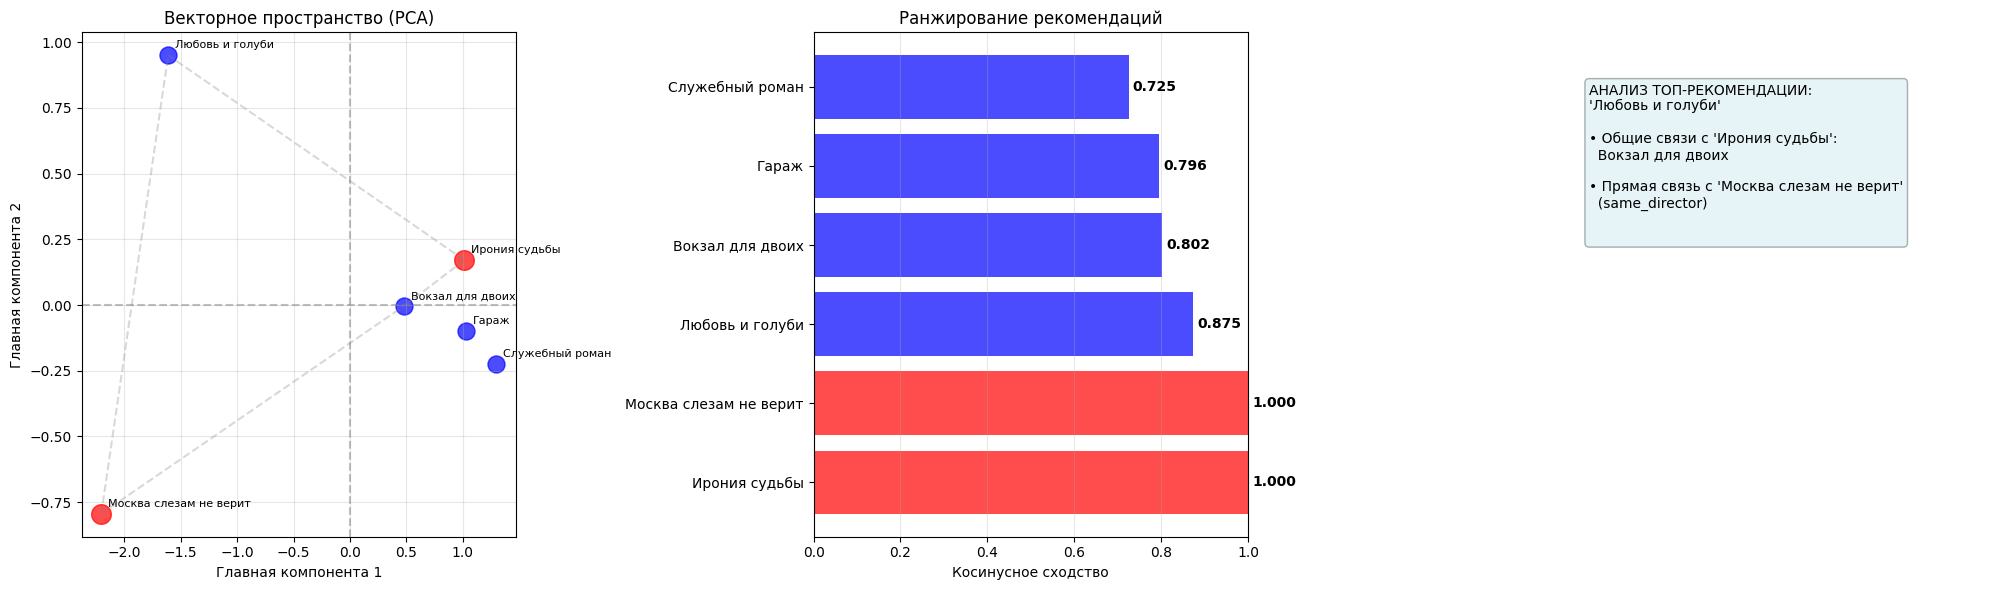



Сценарий 2: Современное российское кино
Описание: Пользователь предпочитает современные драмы
Пользователь смотрел: Брат, Остров
--------------------------------------------------
1. Вычислен средний вектор пользователя
   Размерность: (64,)
   Норма вектора: 2.625
 Получены рекомендации:
   1. Брат 2 (жанр: ИСТОРИЧЕСКИЕ, год: 2000, сходство: 0.885)
   2. Царь (жанр: ИСТОРИЧЕСКИЕ, год: 2009, сходство: 0.825)
   3. Жмурки (жанр: БОЕВИК, год: 2005, сходство: 0.807)
   4. Особенности национальной охоты (жанр: БОЕВИК, год: 1995, сходство: 0.735)


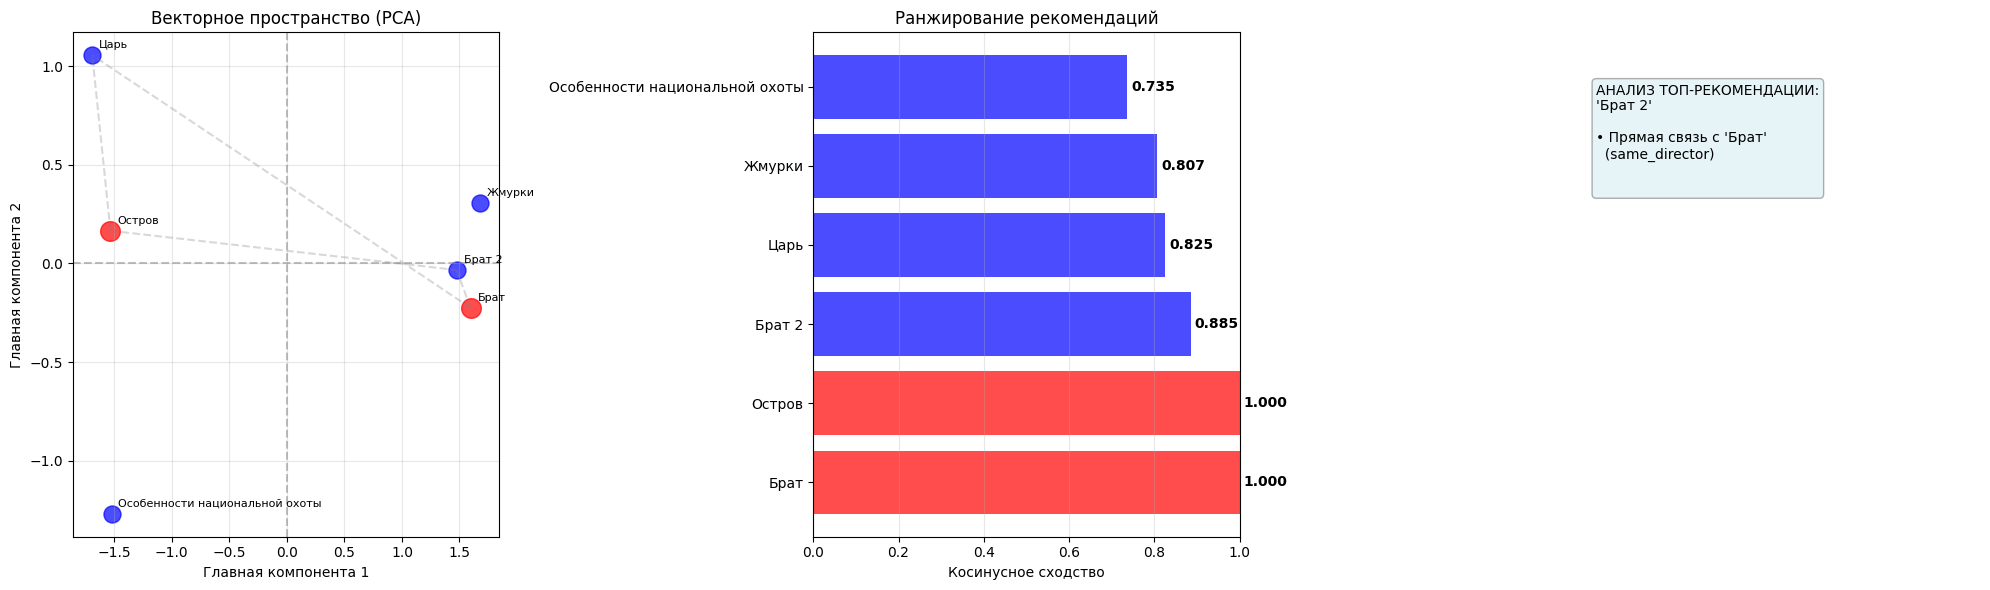



Сценарий 3: Разнообразие жанров
Описание: Пользователь смотрит разные жанры
Пользователь смотрел: Операция Ы, Ночной дозор
--------------------------------------------------
1. Вычислен средний вектор пользователя
   Размерность: (64,)
   Норма вектора: 2.926
 Получены рекомендации:
   1. Дневной дозор (жанр: ФЭНТЕЗИ, год: 2006, сходство: 0.870)
   2. Бриллиантовая рука (жанр: КОМЕДИЯ, год: 1968, сходство: 0.625)
   3. Кавказская пленница (жанр: КОМЕДИЯ, год: 1966, сходство: 0.623)
   4. Брат 2 (жанр: ИСТОРИЧЕСКИЕ, год: 2000, сходство: 0.551)


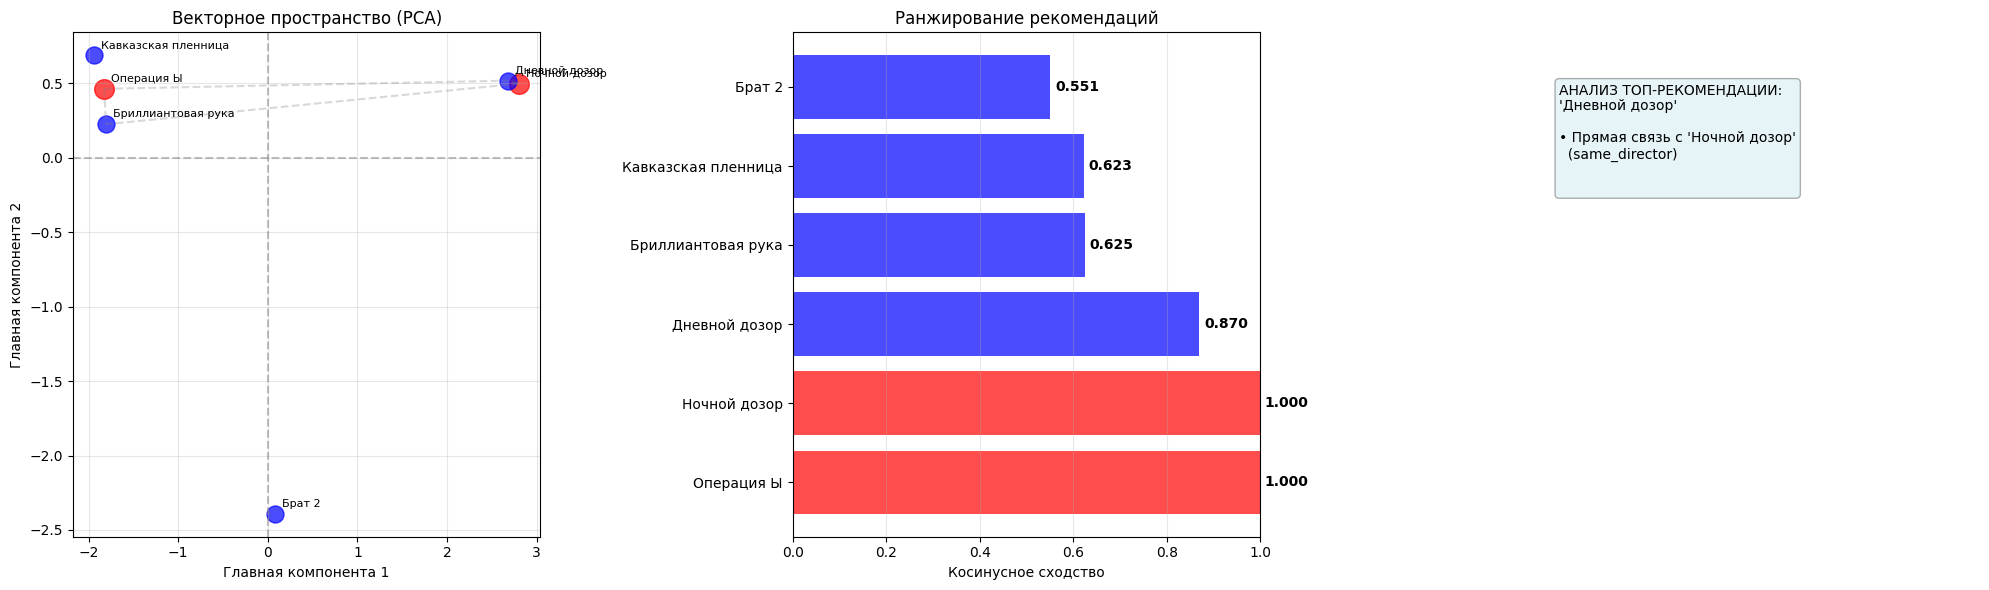

In [43]:
def final_demonstration():
    if global_embeddings is None:
        print("Сначала обучите модель Node2Vec!")
        return

    clear_output(wait=True)
    print("ПОЛНЫЙ ПАЙПЛАЙН GRAPH-BASED РЕКОМЕНДАЦИЙ")

    # полный pipeline с разными сценариями
    scenarios = [
        {
            'name': 'Сценарий 1: Классика советского кино',
            'watched': ['Ирония судьбы', 'Москва слезам не верит'],
            'description': 'Пользователь любит классические советские фильмы'
        },
        {
            'name': 'Сценарий 2: Современное российское кино',
            'watched': ['Брат', 'Остров'],
            'description': 'Пользователь предпочитает современные драмы'
        },
        {
            'name': 'Сценарий 3: Разнообразие жанров',
            'watched': ['Операция Ы', 'Ночной дозор'],
            'description': 'Пользователь смотрит разные жанры'
        }
    ]

    for scenario in scenarios:
        print(f"\n{scenario['name']}")
        print(f"Описание: {scenario['description']}")
        print(f"Пользователь смотрел: {', '.join(scenario['watched'])}")
        print("-" * 50)

        #  все фильмы есть в эмбеддингах
        valid_watched = [movie for movie in scenario['watched'] if movie in global_embeddings]
        if not valid_watched:
            print("Пропуск сценария: ни один фильм не найден в эмбеддингах")
            continue

        # вычисляем средний вектор пользователя
        avg_vector = np.mean([global_embeddings[movie] for movie in valid_watched], axis=0)
        print("1. Вычислен средний вектор пользователя")
        print(f"   Размерность: {avg_vector.shape}")
        print(f"   Норма вектора: {np.linalg.norm(avg_vector):.3f}")

        # получаем рекомендации
        recommendations = get_recommendations(valid_watched, global_embeddings, top_k=4)
        if not recommendations:
            print("Не удалось получить рекомендации для этого сценария")
            continue

        print(" Получены рекомендации:")
        for i, (movie, score) in enumerate(recommendations, 1):
            # Находим информацию о фильме
            movie_info = None
            for genre, films in russian_movies_expanded.items():
                for film in films:
                    if film['title'] == movie:
                        movie_info = film
                        break
                if movie_info:
                    break

            if movie_info:
                print(f"   {i}. {movie} (жанр: {genre}, год: {movie_info['year']}, сходство: {score:.3f})")
            else:
                print(f"   {i}. {movie} (сходство: {score:.3f})")

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

        films_to_plot = valid_watched + [rec[0] for rec in recommendations]
        vectors = []
        labels = []

        for film in films_to_plot:
            if film in global_embeddings:
                vectors.append(global_embeddings[film])
                labels.append(film)

        if len(vectors) >= 2:
            vectors = np.array(vectors)
            pca = PCA(n_components=2)
            vectors_2d = pca.fit_transform(vectors)

            colors = ['red'] * len(valid_watched) + ['blue'] * len(recommendations)
            sizes = [200] * len(valid_watched) + [150] * len(recommendations)

            for i, (vec, label, color, size) in enumerate(zip(vectors_2d, labels, colors, sizes)):
                ax1.scatter(vec[0], vec[1], s=size, color=color, alpha=0.7, label=label)
                ax1.annotate(label, (vec[0], vec[1]), xytext=(5, 5), textcoords='offset points', fontsize=8)

            # просмотренные с рекомендациями
            for i, watched_film in enumerate(valid_watched):
                if watched_film in labels:
                    watched_idx = labels.index(watched_film)
                    for j in range(min(2, len(recommendations))):
                        if recommendations[j][0] in labels:
                            rec_idx = labels.index(recommendations[j][0])
                            ax1.plot([vectors_2d[watched_idx][0], vectors_2d[rec_idx][0]],
                                    [vectors_2d[watched_idx][1], vectors_2d[rec_idx][1]],
                                    'gray', alpha=0.3, linestyle='--')

            ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
            ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
            ax1.grid(True, alpha=0.3)
            ax1.set_xlabel('Главная компонента 1')
            ax1.set_ylabel('Главная компонента 2')
            ax1.set_title('Векторное пространство (PCA)')
        else:
            ax1.text(0.5, 0.5, 'Недостаточно данных\nдля визуализации',
                    ha='center', va='center', transform=ax1.transAxes)
            ax1.set_title('Векторное пространство')

        #  диаграмма сходства
        all_films = valid_watched + [rec[0] for rec in recommendations]
        similarities = [1.0] * len(valid_watched) + [rec[1] for rec in recommendations]
        bar_colors = ['red'] * len(valid_watched) + ['blue'] * len(recommendations)

        y_pos = np.arange(len(all_films))
        bars = ax2.barh(y_pos, similarities, color=bar_colors, alpha=0.7)
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(all_films)
        ax2.set_xlabel('Косинусное сходство')
        ax2.set_title('Ранжирование рекомендаций')
        ax2.set_xlim(0, 1)
        ax2.grid(True, alpha=0.3, axis='x')

        for i, (bar, sim) in enumerate(zip(bars, similarities)):
            ax2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                    f'{sim:.3f}', va='center', fontweight='bold')

        # анализ связей для топ-рекомендации
        if recommendations:
            top_recommendation = recommendations[0][0]
            ax3.axis('off')
            explanation_text = f"АНАЛИЗ ТОП-РЕКОМЕНДАЦИИ:\n'{top_recommendation}'\n\n"

            connections_found = False
            for watched_film in valid_watched:
                if G_complete.has_edge(watched_film, top_recommendation):
                    edge_data = G_complete[watched_film][top_recommendation]
                    relation = edge_data.get('relation', 'связь')
                    explanation_text += f"• Прямая связь с '{watched_film}'\n  ({relation})\n\n"
                    connections_found = True
                else:
                    common_neighbors = set(G_complete.neighbors(watched_film)) & set(G_complete.neighbors(top_recommendation))
                    if common_neighbors:
                        explanation_text += f"• Общие связи с '{watched_film}':\n  {', '.join(list(common_neighbors)[:2])}\n\n"
                        connections_found = True

            if not connections_found:
                explanation_text += "• Структурное сходство в графе\n(близкие векторные представления)"

            ax3.text(0.1, 0.9, explanation_text, transform=ax3.transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

        plt.tight_layout()
        plt.show()

        print("\n" + "=" * 50)

print("Запуск финальной демонстрации...")
final_demonstration()

In [44]:
print("ИНТЕРАКТИВНАЯ ФИНАЛЬНАЯ ДЕМОНСТРАЦИЯ")

def interactive_final_demonstration(user_movies=None, top_k=5, show_vectors=True, show_similarity=True):

    if global_embeddings is None:
        print("Сначала обучите модель Node2Vec в предыдущих разделах!")
        return

    clear_output(wait=True)

    # если фильмы не переданы, используем демо-набор
    if user_movies is None:
        user_movies = ['Ирония судьбы', 'Бриллиантовая рука']

    print("ПОЛНЫЙ ПАЙПЛАЙН РЕКОМЕНДАЦИЙ")
    print(f"Пользователь смотрел: {', '.join(user_movies)}")
    print("-" * 40)

    # Проверяем, что все выбранные фильмы есть в эмбеддингах
    valid_user_movies = [movie for movie in user_movies if movie in global_embeddings]
    if len(valid_user_movies) != len(user_movies):
        missing = set(user_movies) - set(valid_user_movies)
        print(f"Предупреждение: следующие фильмы отсутствуют в эмбеддингах и будут пропущены: {', '.join(missing)}")
        user_movies = valid_user_movies

    if not user_movies:
        print("Нет валидных фильмов для анализа!")
        return

    #  средний вектор пользователя
    avg_vector = np.mean([global_embeddings[movie] for movie in user_movies], axis=0)
    print("1. Вычислен средний вектор пользователя")
    print(f"   Размерность: {avg_vector.shape}")
    print(f"   Норма вектора: {np.linalg.norm(avg_vector):.3f}")

    # получаем рекомендации
    recommendations = get_recommendations(user_movies, global_embeddings, top_k=top_k)
    print(f"2. Получены топ-{top_k} рекомендаций:")

    for i, (movie, score) in enumerate(recommendations, 1):
        # определяем жанр и информацию о фильме из расширенного датасета
        movie_info = None
        movie_genre = 'Неизвестно'
        movie_year = '?'

        for genre, films in russian_movies_expanded.items():
            for film_info_item in films:
                if film_info_item['title'] == movie:
                    movie_info = film_info_item
                    movie_genre = genre
                    movie_year = film_info_item['year']
                    break
            if movie_info:
                break

        print(f"   {i}. {movie} (сходство: {score:.3f}) | Жанр: {movie_genre} | Год: {movie_year}")


    fig = plt.figure(figsize=(18, 12))

    if show_vectors and show_similarity:
        #  векторы + сходство + анализ
        gs = fig.add_gridspec(2, 2, height_ratios=[2, 1])
        ax1 = fig.add_subplot(gs[0, :])  # векторное пространство
        ax2 = fig.add_subplot(gs[1, 0])  # сходство
        ax3 = fig.add_subplot(gs[1, 1])  # анализ связей
    elif show_vectors:

        ax1 = fig.add_subplot(111)
    else:

        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)


    if show_vectors:
        films_to_plot = user_movies + [rec[0] for rec in recommendations]
        colors = ['red'] * len(user_movies) + ['blue'] * len(recommendations)
        sizes = [300] * len(user_movies) + [200] * len(recommendations)

        vectors_to_plot = []
        labels_to_plot = []

        for film in films_to_plot:
            if film in global_embeddings:
                vectors_to_plot.append(global_embeddings[film])
                labels_to_plot.append(film)

        if len(vectors_to_plot) >= 2:
            vectors_to_plot = np.array(vectors_to_plot)
            pca = PCA(n_components=2)
            vectors_2d = pca.fit_transform(vectors_to_plot)

            # объясненная дисперсия
            explained_variance = pca.explained_variance_ratio_.sum()

            for i, (vec, film, color, size) in enumerate(zip(vectors_2d, labels_to_plot, colors, sizes)):
                ax1.scatter(vec[0], vec[1], s=size, color=color,
                           alpha=0.7, label=film, edgecolors='black', linewidth=2)
                ax1.annotate(film, (vec[0], vec[1]),
                            xytext=(10, 10), textcoords='offset points',
                            fontweight='bold',
                            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

            # стрелки от просмотренных к рекомендованным (топ-3)
            for i, user_movie in enumerate(user_movies):
                if user_movie in labels_to_plot:
                    user_idx = labels_to_plot.index(user_movie)
                    for j in range(min(3, len(recommendations))):
                        if recommendations[j][0] in labels_to_plot:
                            rec_idx = labels_to_plot.index(recommendations[j][0])
                            ax1.plot([vectors_2d[user_idx][0], vectors_2d[rec_idx][0]],
                                    [vectors_2d[user_idx][1], vectors_2d[rec_idx][1]],
                                    'gray', alpha=0.3, linestyle='--')

            ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
            ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
            ax1.grid(True, alpha=0.3)
            ax1.set_xlabel(f'Главная компонента 1 ({pca.explained_variance_ratio_[0]:.1%})')
            ax1.set_ylabel(f'Главная компонента 2 ({pca.explained_variance_ratio_[1]:.1%})')
            ax1.set_title(f'Векторное пространство фильмов (объясненная дисперсия: {explained_variance:.1%})')

            # легенда
            legend_elements = [
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red',
                          markersize=10, label='Просмотренные'),
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue',
                          markersize=8, label='Рекомендации')
            ]
            ax1.legend(handles=legend_elements, loc='upper right')
        else:
            ax1.text(0.5, 0.5, 'Недостаточно данных\nдля визуализации',
                    ha='center', va='center', transform=ax1.transAxes, fontsize=12)
            ax1.set_title('Векторное пространство')

    # визуализация сходства
    if show_similarity and 'ax2' in locals():
        all_films = user_movies + [rec[0] for rec in recommendations]
        similarities = [1.0] * len(user_movies) + [rec[1] for rec in recommendations]
        bar_colors = ['red'] * len(user_movies) + ['blue'] * len(recommendations)

        bars = ax2.barh(range(len(all_films)), similarities, color=bar_colors, alpha=0.7)
        ax2.set_yticks(range(len(all_films)))
        ax2.set_yticklabels(all_films, fontsize=9)
        ax2.set_xlabel('Косинусное сходство')
        ax2.set_title('Ранжирование рекомендаций')
        ax2.set_xlim(0, 1)
        ax2.grid(True, alpha=0.3, axis='x')

        for i, (bar, sim) in enumerate(zip(bars, similarities)):
            ax2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                    f'{sim:.3f}', va='center', fontweight='bold', fontsize=8)

    # анализ связей для топ-рекомендации
    if 'ax3' in locals() and recommendations:
        ax3.axis('off')
        top_recommendation = recommendations[0][0]

        analysis_text = f"АНАЛИЗ ТОП-РЕКОМЕНДАЦИИ:\n'{top_recommendation}'\n\n"

        # находим информацию о топ-рекомендации
        top_movie_info = None
        for genre, films in russian_movies_expanded.items():
            for film_info in films:
                if film_info['title'] == top_recommendation:
                    top_movie_info = film_info
                    break
            if top_movie_info:
                break

        if top_movie_info:
            analysis_text += f"Жанр: {genre}\n"
            analysis_text += f"Год: {top_movie_info['year']}\n"
            analysis_text += f"Рейтинг: {top_movie_info['rating']}\n\n"

        # анализ связей
        connections_found = False
        for user_movie in user_movies:
            if G_complete.has_edge(user_movie, top_recommendation):
                edge_data = G_complete[user_movie][top_recommendation]
                relation = edge_data.get('relation', 'связь')
                analysis_text += f"• Прямая связь с '{user_movie}'\n  ({relation})\n\n"
                connections_found = True
            else:
                # ищем общих соседей
                common_neighbors = set(G_complete.neighbors(user_movie)) & set(G_complete.neighbors(top_recommendation))
                if common_neighbors:
                    common_list = list(common_neighbors)[:2]
                    analysis_text += f"• Общие связи с '{user_movie}':\n  {', '.join(common_list)}\n\n"
                    connections_found = True

        if not connections_found:
            analysis_text += "• Структурное сходство в графе\n(близкие векторные представления)"

        ax3.text(0.05, 0.95, analysis_text, transform=ax3.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

    plt.tight_layout()
    plt.show()

    print("ДЕТАЛЬНЫЙ АНАЛИЗ РЕКОМЕНДАЦИЙ")


    print("ОБЪЯСНЕНИЕ РЕКОМЕНДАЦИЙ:")
    for movie, score in recommendations:
        print(f"\n• {movie} (сходство: {score:.3f}):")

        # связи с просмотренными фильмами
        connections = []
        for user_movie in user_movies:
            # проверяем прямые связи в графе
            if G_complete.has_edge(movie, user_movie):
                edge_data = G_complete[movie][user_movie]
                relation = edge_data.get('relation', 'связь')
                connections.append(f"прямая связь с '{user_movie}' ({relation})")

            # проверяем общих соседей
            movie_neighbors = set(G_complete.neighbors(movie))
            user_neighbors = set(G_complete.neighbors(user_movie))
            common_neighbors = movie_neighbors.intersection(user_neighbors)

            if common_neighbors:
                connections.append(f"общие связи с '{user_movie}': {', '.join(list(common_neighbors)[:2])}")

        if connections:
            print(f"  Причины: {', '.join(connections[:2])}")
        else:
            # если прямых связей нет, ищем структурное сходство
            print(f"  Структурное сходство в графе (близкие векторные представления)")

    print(f"ТЕХНИЧЕСКИЕ ДЕТАЛИ:")
    print(f"• Использовано {len(user_movies)} фильмов для построения профиля")
    print(f"• Размерность векторных представлений: {list(global_embeddings.values())[0].shape[0]}")

    # Подсчитываем общее количество фильмов-кандидатов
    total_candidates = 0
    for genre, films in russian_movies_expanded.items():
        for film_info in films:
            if film_info['title'] in global_embeddings and film_info['title'] not in user_movies:
                total_candidates += 1

    print(f"• Всего кандидатов для рекомендаций: {total_candidates}")


# интерактивный интерфейс для финальной демонстрации
def create_interactive_final_demo():

    if global_embeddings is None:
        print("Сначала обучите модель Node2Vec!")
        return

    clear_output(wait=True)
    print("ИНТЕРАКТИВНАЯ ФИНАЛЬНАЯ ДЕМОНСТРАЦИЯ")
    print("Настройте параметры и посмотрите, как работает система рекомендаций!\n")

    # доступные фильмы для выбора из расширенного датасета
    available_films = []
    for genre, films in russian_movies_expanded.items():
        for film_info in films:
            film_title = film_info['title']
            if film_title in global_embeddings:
                available_films.append(film_title)

    available_films.sort()

    # виджеты для выбора фильмов
    film_dropdowns = []
    for i in range(5):  # до 5 фильмов для выбора
        dropdown = widgets.Dropdown(
            options=[''] + available_films,
            value='',
            description=f'Фильм {i+1}:',
            disabled=False,
            layout=widgets.Layout(width='280px')
        )
        film_dropdowns.append(dropdown)

    # другие настройки
    top_k_slider = widgets.IntSlider(
        value=5,
        min=3,
        max=10,
        step=1,
        description='Кол-во рекомендаций:',
        continuous_update=False,
        style={'description_width': 'initial'}
    )

    show_vectors_check = widgets.Checkbox(
        value=True,
        description='Показать векторное пространство',
        disabled=False
    )

    show_similarity_check = widgets.Checkbox(
        value=True,
        description='Показать анализ связей',
        disabled=False
    )

    # кнопка запуска
    run_button = widgets.Button(
        description=' Запустить рекомендации',
        button_style='success',
        tooltip='Запуск системы рекомендаций',
        layout=widgets.Layout(width='250px', height='40px', margin='20px')
    )

    output = widgets.Output()

    def on_run_click(b):
        with output:
            clear_output(wait=True)

            # выбранные фильмы
            selected_films = [dropdown.value for dropdown in film_dropdowns if dropdown.value]

            if not selected_films:
                print(" Пожалуйста, выберите хотя бы один фильм!")
                return

            interactive_final_demonstration(
                user_movies=selected_films,
                top_k=top_k_slider.value,
                show_vectors=show_vectors_check.value,
                show_similarity=show_similarity_check.value
            )

    run_button.on_click(on_run_click)

    # группируем элементы управления
    films_header = widgets.HTML("<h3> Выберите просмотренные фильмы:</h3>")
    films_grid = widgets.GridBox(film_dropdowns,
                                layout=widgets.Layout(grid_template_columns="repeat(2, 300px)"))

    settings_header = widgets.HTML("<h3> Настройки визуализации:</h3>")
    settings_box = widgets.VBox([
        top_k_slider,
        show_vectors_check,
        show_similarity_check
    ], layout=widgets.Layout(margin='10px'))

    display(widgets.VBox([
        films_header,
        films_grid,
        widgets.HTML("<br>"),
        settings_header,
        settings_box,
        widgets.HTML("<br>"),
        widgets.HBox([run_button], layout=widgets.Layout(justify_content='center')),
        output
    ]))

# предопределенные сценарии для быстрого тестирования
def predefined_scenarios():
    """Предопределенные сценарии для демонстрации"""

    scenarios = {
        " Классика советского кино": ['Ирония судьбы', 'Москва слезам не верит', 'Бриллиантовая рука'],
        " Комедии Гайдая": ['Операция Ы', 'Кавказская пленница', 'Бриллиантовая рука'],
        " Драмы и история": ['Летят журавли', 'Война и мир', 'Андрей Рублев'],
        " Фэнтези и сказки": ['Чародеи', 'Обыкновенное чудо', 'Тот самый Мюнхгаузен'],
        " Современное кино": ['Ночной дозор', 'Сибирский цирюльник', 'Остров']
    }

    print("БЫСТРЫЕ СЦЕНАРИИ ДЛЯ ТЕСТИРОВАНИЯ:")

    buttons = []
    for scenario_name, films in scenarios.items():
        button = widgets.Button(
            description=scenario_name,
            button_style='info',
            tooltip=f"Запустить: {', '.join(films)}",
            layout=widgets.Layout(width='220px', height='40px', margin='5px')
        )

        def create_handler(selected_films):
            def handler(b):
                clear_output(wait=True)
                print(f" Запуск сценария: {b.description}")
                print(f" Фильмы: {', '.join(selected_films)}")
                print("-" * 50)
                interactive_final_demonstration(user_movies=selected_films, top_k=6, show_vectors=True, show_similarity=True)
            return handler

        button.on_click(create_handler(films))
        buttons.append(button)


    buttons_grid = widgets.GridBox(buttons,
                                 layout=widgets.Layout(grid_template_columns="repeat(2, 220px)"))
    display(buttons_grid)
    print("\n")


# предопределенные сценарии
predefined_scenarios()

# кастомный интерфейс
create_interactive_final_demo()

# Дополнительная информация
print("\n" + "=" * 70)
print("📋 ИНСТРУКЦИЯ ПО ИСПОЛЬЗОВАНИЮ:")
print("=" * 70)
print("1.  Быстрые сценарии - нажмите на кнопку для тестирования готовых наборов фильмов")
print("2.  Кастомный выбор - выберите до 5 фильмов в выпадающих списках")
print("3.  Настройте количество рекомендаций и тип визуализации")
print("4.  Нажмите 'Запустить рекомендации' для построения персонализированных рекомендаций")
print("5.  Анализируйте результаты: векторные представления, сходство и связи между фильмами")
print("\n СИСТЕМА ПОКАЖЕТ:")
print("•  Векторное пространство фильмов (PCA проекция)")
print("•  Ранжирование по косинусному сходству")
print("•  Анализ графовых связей между фильмами")
print("•  Объяснение причин рекомендаций на основе структуры графа")

ИНТЕРАКТИВНАЯ ФИНАЛЬНАЯ ДЕМОНСТРАЦИЯ
Настройте параметры и посмотрите, как работает система рекомендаций!




📋 ИНСТРУКЦИЯ ПО ИСПОЛЬЗОВАНИЮ:
1.  Быстрые сценарии - нажмите на кнопку для тестирования готовых наборов фильмов
2.  Кастомный выбор - выберите до 5 фильмов в выпадающих списках
3.  Настройте количество рекомендаций и тип визуализации
4.  Нажмите 'Запустить рекомендации' для построения персонализированных рекомендаций
5.  Анализируйте результаты: векторные представления, сходство и связи между фильмами

 СИСТЕМА ПОКАЖЕТ:
•  Векторное пространство фильмов (PCA проекция)
•  Ранжирование по косинусному сходству
•  Анализ графовых связей между фильмами
•  Объяснение причин рекомендаций на основе структуры графа


https://docs.oracle.com/en/database/oracle/property-graph/25.3/pypgx/pypgx/prog-guides/mllib/deepwalk.html